In [1]:
class Value:
    """stores a single scalar value and its gradient"""

    def __init__(self, data, _children=()):
        self.data = data    # data contains the value of this variable
        self.grad = 0    # grad contains the gradient, it must be initialized with zero
        # internal variables used for autograd graph construction
        self._backward = lambda: None    # initialize backward step with empty fuction
        self._prev = set(_children)    # _prev contains child nodes

    # forward and backward pass for basic operations

    def __add__(self, other):
        """operator + (addition: self + other)"""

        # other needs to be an instance of class Value (self.__class__)
        if not isinstance(other, self.__class__):
            other = self.__class__(other)

        # calculate the sum
        forward_result = self.data + other.data

        # create a new Value (self.__class__) that can store the result and the calculation tree
        out =  self.__class__(data=forward_result, _children=(self, other))

        # backward path: both children get same (full) gradient
        def _backward():
            # calculate gradient and add it to grad:
            # adding the gradient is necessary, since a Value can get gradient information
            # from multiple other Value nodes and these gradients must sum up
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

    def __mul__(self, other):
        """operator * (multiplication: self * other)"""

        # other needs to be an instance of class Value (self.__class__)
        if not isinstance(other, self.__class__):
            other = self.__class__(other)

        # calculate the product
        forward_result = self.data * other.data

        # create a new Value (self.__class__) that can store the result and the calculation tree
        out = self.__class__(data=forward_result, _children=(self, other))

        # backward path: partial derivative for self and other
        def _backward():
            # calculate gradient and add it to grad:
            # adding the gradient is necessary, since a Value can get gradient information
            # from multiple other Value nodes and these grudients must sum up
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

    # gradient descent starting from this node
    def backward(self, grad=1):
        """backpropagates the gradient to all children starting from this node"""

        # topological order all of the children in the graph
        topo = []    # remember the order in which the nodes must be processed
        visited = set()    # remember nodes that have been visited already

        # breadth-first search to find the processing order of the nodes in the graph
        def build_topo(v):
            if v not in visited:    # if the node is not visited yet
                visited.add(v)    # remember that it is visited now and should not be visited once more
                for child in v._prev:    # for each child node of this node
                    build_topo(child)    # visit each child node
                topo.append(v)    # insert this node at the end of the list of processing order
                # (please notice, that all child nodes will be inserted earlier)

        # start the breadth-first search from this node
        build_topo(self)    # (please notice, that this node will be inserted as last element of the processing list)

        # initialize the gardient of this node with the given value
        self.grad = grad

        # go one variable at a time and apply the chain rule to get its gradient
        for v in reversed(topo):    # in reverse order of the processing list that was build above
            v._backward()    # call the _backward function that is specified for each operation

In [2]:
x = Value(5)

z = x*x*3 + x*2 
y = z*z   
print(f'z = {z.data}')
print(f'y = {y.data}')

z = 85
y = 7225


In [4]:
dLdy = 2

# reset gradients

x.grad = 0
z.grad = 0


# calculate all gradients
y.backward(grad=dLdy)

print(f'dL/dz = {z.grad}')
print(f'dL/dx = {x.grad}')

dL/dz = 340
dL/dx = 10880


In [5]:
class Value(Value):
    def __pow__(self, other):
        """operator ** (power: self ** other)"""
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'

        # calculate the product
        forward_result = self.data ** other  

        # create a new Value (self.__class__) that can store the result and the calculation tree
        out = self.__class__(data=forward_result, _children=(self,))

        # backward path: deviation
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

In [6]:
x = Value(5)

z = x ** 2 * 3 + x * 2
y =  z ** 2 

print(f'z = {z.data}')
print(f'y = {y.data}')

dLdy = 2

# reset gradients
z.grad = 0
x.grad = 0

# calculate all gradients
y.backward(grad=dLdy)

print(f'dL/dz = {z.grad}')
print(f'dL/dx = {x.grad}')

z = 85
y = 7225
dL/dz = 340
dL/dx = 10880


In [7]:
class Value(Value):
    def __neg__(self):
        """negation: -self"""
        return self * -1

    def __sub__(self, other):
        """operator - (subtraction: self - other)"""
        return self + (-other)

    def __truediv__(self, other):
        """operator / (division: self / other)"""
        return self * other ** -1

    def __radd__(self, other):
        """operator + (addition with Value as right-hand operand: other + self)"""
        return self + other

    def __rsub__(self, other):
        """operator - (subtraction with Value as right-hand operand: other - self)"""
        return other + (-self)

    def __rmul__(self, other):
        """operator * (multiplication with Value as right-hand operand: other * self)"""
        return self * other

    def __rtruediv__(self, other):
        """operator / (division with Value as right-hand operand: other / self)"""
        return other * self ** -1

    # define how the Value class is printed
    def __repr__(self):
        """string representation of this class"""
        return f"Value(data={self.data}, grad={self.grad})"

In [8]:
x = Value(0) 
y =  x - 1 / (x**2 + 1)
x.grad = 0
y.backward()
print(f"y'(0) = {x.grad}")

y'(0) = 1.0


In [9]:
x_1, t_1 = (1, 2)
x_2, t_2 = (2, 2.3)
x_3, t_3 = (3, 3)
pts = [(x_1, t_1), (x_2, t_2), (x_3, t_3)]

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_line(pts, m, n, s=0):
    x_coords = np.array(pts)[:, 0]
    y_coords = np.array(pts)[:, 1]
    x_values = np.linspace(0, 4, 200)
    y_values = m * x_values + n
    plt.plot(x_values, y_values, 'b-')
    plt.plot(x_coords, y_coords, 'ro')
    plt.axis([0, 4, 0, 4])
    plt.show()

def print_progress_line():
    print(f'epoch {(epoch + 1)}:\n\tloss = {loss.data:.4f}, w = {w.data:.4f}, b = {b.data:.4f}\n\tdL/dw = {w.grad:.4f}, dL/db = {b.grad:.4f}')

initial configuration:


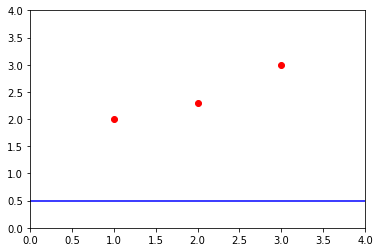



epoch 1:
	loss = 3.9133, w = 0.7560, b = 0.8480
	dL/dw = -8.4000, dL/db = -3.8667


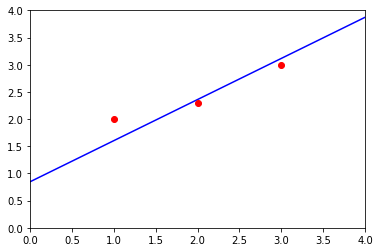



epoch 2:
	loss = 0.0580, w = 0.7517, b = 0.8612
	dL/dw = 0.0480, dL/db = -0.1467


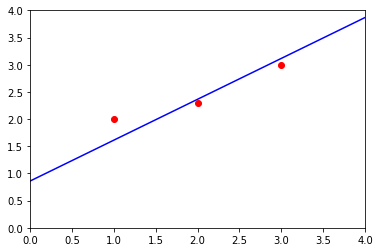



epoch 10:
	loss = 0.0435, w = 0.7113, b = 0.9530
	dL/dw = 0.0519, dL/db = -0.1180


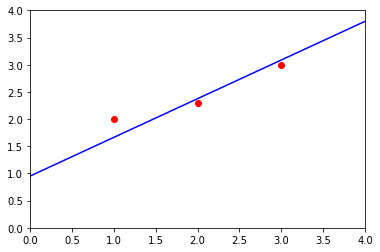



epoch 50:
	loss = 0.0149, w = 0.5881, b = 1.2331
	dL/dw = 0.0216, dL/db = -0.0492


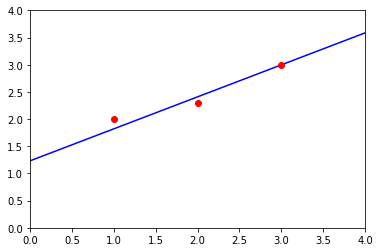



epoch 100:
	loss = 0.0096, w = 0.5295, b = 1.3663
	dL/dw = 0.0073, dL/db = -0.0165


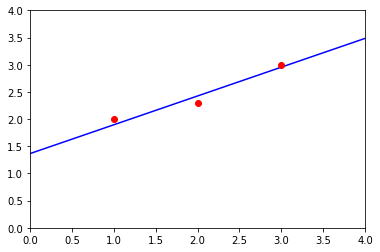



epoch 200:
	loss = 0.0089, w = 0.5033, b = 1.4258
	dL/dw = 0.0008, dL/db = -0.0018


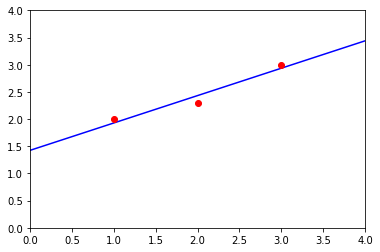



epoch 300:
	loss = 0.0089, w = 0.5004, b = 1.4325
	dL/dw = 0.0001, dL/db = -0.0002


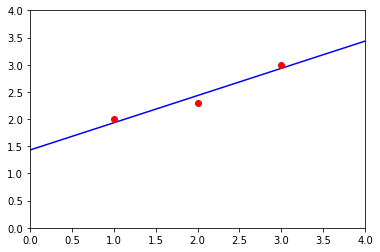



epoch 400:
	loss = 0.0089, w = 0.5000, b = 1.4332
	dL/dw = 0.0000, dL/db = -0.0000


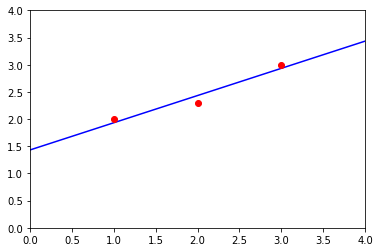



final result:
epoch 500:
	loss = 0.0089, w = 0.5000, b = 1.4333
	dL/dw = 0.0000, dL/db = -0.0000


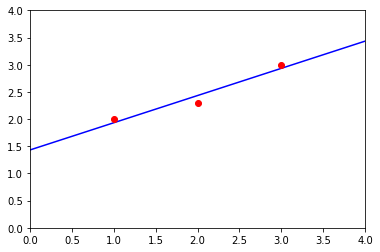

In [11]:
# initialize weight and bias weight (ensure to enable automatic differentiation by using the class Value)
w = Value(0)  
b = Value(0.5)

# set learning rate
learning_rate = 0.09

# show points and initial neuron configuration
print('initial configuration:')
visualize_line(pts, w.data, b.data)
print('\n')

# fit neuron to points
for epoch in range(500):   # train for 500 epochs
    # reset gradients
    w.grad = 0   
    b.grad = 0   

    # output of neuron (y_i = w * x_i + b) for all three inputs x_1, x_2, and x_3
    y_1 = w * x_1 + b 
    y_2 = w * x_2 + b 
    y_3 = w * x_3 + b 

    # calculate squared error for each sample: squared_error_i = (y_i - t_i) ** 2
    squared_error_1 = (y_1 - t_1) ** 2 
    squared_error_2 = (y_2 - t_2) ** 2 
    squared_error_3 = (y_3 - t_3) ** 2 

    # calculate loss (see formula above, use results for squared_error_i)
    loss = 1 / 3 * (squared_error_1 + squared_error_2 + squared_error_3 ) 

    # calculate gradients: call backward function for loss
    loss.backward()  

    # update parameters with gradients: w_new = w_old - dL/dw * learning_rate
    w.data =  w.data - w.grad * learning_rate
    b.data =  b.data - b.grad * learning_rate

    # report progress
    if epoch in [0, 1, 9, 49, 99, 199, 299, 399]:
        print_progress_line()
        visualize_line(pts, w.data, b.data)
        print('\n')

# report final result
print('final result:')
print_progress_line()
visualize_line(pts, w.data, b.data)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_parabola(pts, a, b, c):
    x_coords = np.array(pts)[:, 0]
    y_coords = np.array(pts)[:, 1]
    x_values = np.linspace(0, 4, 200)
    y_values = a * np.square(x_values) + b * x_values + c
    plt.plot(x_values, y_values, 'b-')
    plt.plot(x_coords, y_coords, 'ro')
    plt.axis([0, 4, 0, 4])
    plt.show()

def print_progress_parabola(a, b, c):
    print(f'epoch {(epoch + 1)}:\n\tloss = {loss.data:.4f}, w1 = {w1.data:.4f}, b1 = {b1.data:.4f}, w2 = {w2.data:.4f}, b2 = {b2.data:.4f}\n\tdL/dw1 = {w1.grad:.4f}, dL/db1 = {b1.grad:.4f}, dL/dw2 = {w2.grad:.4f}, dL/db2 = {b2.grad:.4f}\n\ta = {a:.4f}, b = {b:.4f}, c = {c:.4f}')

Realisierung der Regression unter Verwendung der Klasse `Value`:

initial configuration:


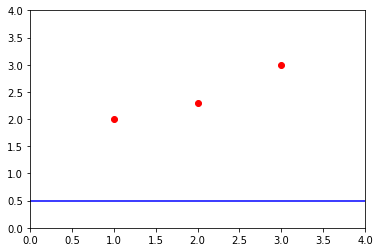



epoch 1:
	loss = 3.9133, w1 = 0.0100, b1 = 0.0100, w2 = 0.0004, b2 = 0.8480
	dL/dw1 = 0.0000, dL/db1 = 0.0000, dL/dw2 = -0.0041, dL/db2 = -3.8667
	a = 0.0000, b = 0.0000, c = 0.8480


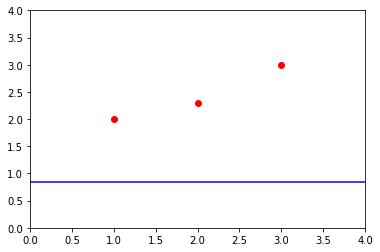



epoch 5:
	loss = 0.9396, w1 = 0.0101, b1 = 0.0100, w2 = 0.0014, b2 = 1.7166
	dL/dw1 = -0.0004, dL/db1 = -0.0001, dL/dw2 = -0.0021, dL/db2 = -1.7482
	a = 0.0000, b = 0.0000, c = 1.7166


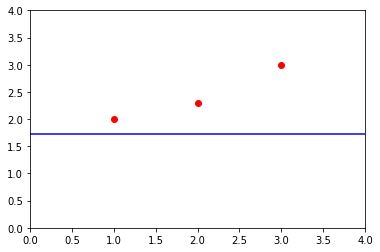



epoch 50:
	loss = 0.1756, w1 = 0.0111, b1 = 0.0103, w2 = 0.0039, b2 = 2.4332
	dL/dw1 = -0.0003, dL/db1 = -0.0001, dL/dw2 = -0.0005, dL/db2 = -0.0002
	a = 0.0000, b = 0.0000, c = 2.4332


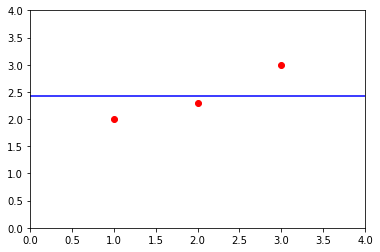



epoch 200:
	loss = 0.1755, w1 = 0.0235, b1 = 0.0129, w2 = 0.0161, b2 = 2.4333
	dL/dw1 = -0.0023, dL/db1 = -0.0005, dL/dw2 = -0.0019, dL/db2 = 0.0000
	a = 0.0000, b = 0.0000, c = 2.4333


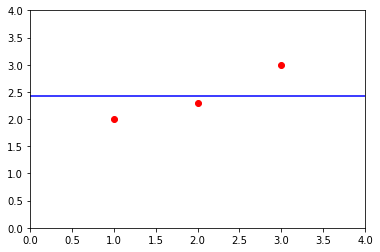



epoch 300:
	loss = 0.1570, w1 = 0.2189, b1 = 0.0560, w2 = 0.1595, b2 = 2.4124
	dL/dw1 = -0.1572, dL/db1 = -0.0333, dL/dw2 = -0.1138, dL/db2 = 0.0371
	a = 0.0076, b = 0.0039, c = 2.4129


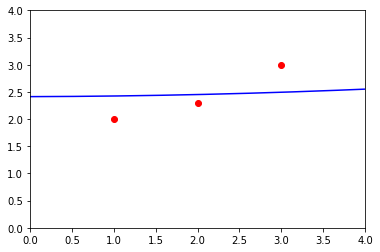



epoch 320:
	loss = 0.0314, w1 = 0.4822, b1 = 0.0454, w2 = 0.3422, b2 = 2.1119
	dL/dw1 = -0.0640, dL/db1 = 0.0386, dL/dw2 = -0.0423, dL/db2 = 0.1692
	a = 0.0796, b = 0.0150, c = 2.1126


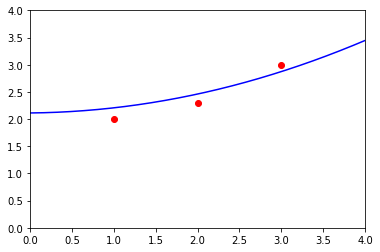



epoch 350:
	loss = 0.0019, w1 = 0.5564, b1 = -0.0183, w2 = 0.3932, b2 = 1.8949
	dL/dw1 = -0.0096, dL/db1 = 0.0117, dL/dw2 = -0.0070, dL/db2 = 0.0292
	a = 0.1217, b = -0.0080, c = 1.8951


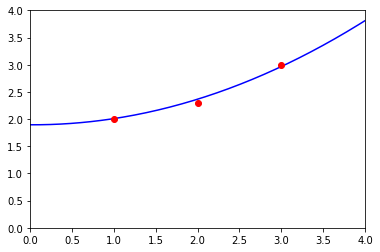



epoch 400:
	loss = 0.0011, w1 = 0.5703, b1 = -0.0438, w2 = 0.4041, b2 = 1.8597
	dL/dw1 = -0.0008, dL/db1 = 0.0034, dL/dw2 = -0.0008, dL/db2 = 0.0001
	a = 0.1314, b = -0.0202, c = 1.8605


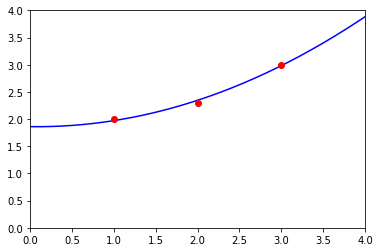



epoch 1000:
	loss = 0.0005, w1 = 0.5886, b1 = -0.2011, w2 = 0.4395, b2 = 1.9127
	dL/dw1 = -0.0002, dL/db1 = 0.0027, dL/dw2 = -0.0008, dL/db2 = -0.0009
	a = 0.1523, b = -0.1041, c = 1.9305


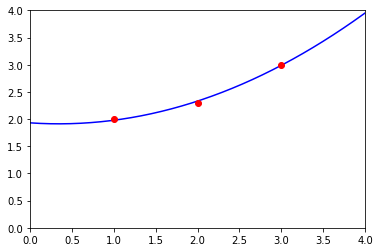



epoch 2000:
	loss = 0.0001, w1 = 0.6031, b1 = -0.3805, w2 = 0.5039, b2 = 1.9674
	dL/dw1 = -0.0001, dL/db1 = 0.0012, dL/dw2 = -0.0005, dL/db2 = -0.0003
	a = 0.1833, b = -0.2313, c = 2.0404


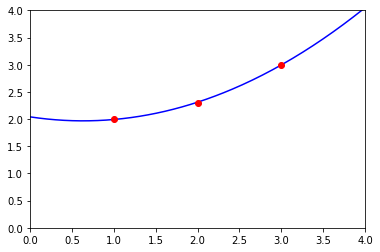



final result:
epoch 4000:
	loss = 0.0000, w1 = 0.6092, b1 = -0.4544, w2 = 0.5371, b2 = 1.9868
	dL/dw1 = -0.0000, dL/db1 = 0.0001, dL/dw2 = -0.0000, dL/db2 = -0.0000
	a = 0.1994, b = -0.2974, c = 2.0977


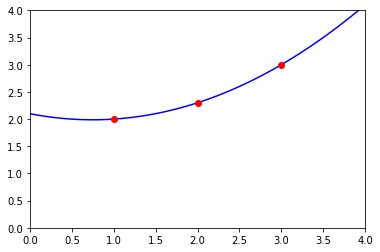

In [13]:
# initialize weights and bias weights (ensure to enable automatic differentiation by using the class Value)
w1 = Value(0.01)
b1 = Value(0.01)
w2 = Value(0)   
b2 = Value(0.5 )

# set learning rate
learning_rate = 0.09

# show points and parabula defined by initial neural network
print('initial configuration:')
# calculate parameters of parabola
a = w1.data ** 2 * w2.data
b = 2 * w1.data * w2.data * b1.data
c = w2.data * b1.data ** 2 + b2.data
visualize_parabola(pts, a, b, c)
print('\n')

# fit neural network to points
for epoch in range(4000):   # train for 4000 epochs
    # reset gradients
    w1.grad =  0 
    b1.grad =  0 
    w2.grad =  0 
    b2.grad =  0 

    # output of neuron (y_i = w2 * (w1 * x_i + b1) ** 2 + b2) for all three inputs x_1, x_2, and x_3
    y_1 = w2 * ((w1 * x_1 + b1) ** 2) + b2 
    y_2 = w2 * ((w1 * x_2 + b1) ** 2) + b2 
    y_3 = w2 * ((w1 * x_3 + b1) ** 2) + b2 

    # calculate squared error for each sample: squared_error_i = (y_i - t_i) ** 2
    squared_error1 =  (y_1 - t_1) ** 2 
    squared_error2 =  (y_2 - t_2) ** 2 
    squared_error3 =  (y_3 - t_3) ** 2 

    # calculate loss (see formula above, use results for squared_error_i)
    loss = 1/3 * (squared_error1 + squared_error2 + squared_error3 ) # bitte Code ergaenzen <---------------- [Luecke (41)]
      # bitte Code ergaenzen <---------------- [Luecke (41)]

    # calculate gradients: call backward function for loss
    loss.backward()   # bitte Code ergaenzen <---------------- [Luecke (42)]

    # update parameters with gradients: w_new = w_old - dL/dw * learning_rate

    w1.data =   w1.data - w1.grad * learning_rate
    b1.data =   b1.data - b1.grad * learning_rate
    w2.data =   w2.data - w2.grad * learning_rate
    b2.data =   b2.data - b2.grad * learning_rate

    # report progress
    if epoch in [0, 4, 49, 199, 299, 319, 349, 399, 999, 1999]:
        a = w1.data ** 2 * w2.data
        b = 2 * w1.data * w2.data * b1.data
        c = w2.data * b1.data ** 2 + b2.data
        print_progress_parabola(a, b, c)
        visualize_parabola(pts, a, b, c)
        print('\n')

# report final result
print('final result:')
a = w1.data ** 2 * w2.data
b = 2 * w1.data * w2.data * b1.data
c = w2.data * b1.data ** 2 + b2.data
print_progress_parabola(a, b, c)
visualize_parabola(pts, a, b, c)

In [14]:
import numpy as np

class Module:
    """base class"""

    def zero_grad(self):
        """reset gradient for all parameters"""
        for p in self.parameters():    # iterate through the list of all parameters
            p.grad = 0    # parameter p is of type Value, it's gradient is set to zero

    def parameters(self):
        """return the parameters, should be overwritten in derived classes"""
        return []

    def forward(self, x):
        """forward pass for input x, should be overwritten in derived classes"""
        return None

    def __call__(self, x):
        """call function for forward pass with input x"""
        return self.forward(x)

In [15]:
import random

class Neuron(Module):
    """implements an abstract interface for a single neuron"""

    def __init__(self, in_features):
        """creation and initialization of this neuron for in_features input neurons"""
        minimum_value = -(1 / in_features) ** 0.5
        maximum_value = (1 / in_features) ** 0.5
        self.w = []    # the neuron needs one weight for each input neuron
        for _ in range(in_features):    # nin = number of input neurons
            initial_value_w_i = random.uniform(minimum_value, maximum_value)    # random uniform initialization
            w_i = Value(initial_value_w_i)    # make this weight differentiable, set initial value
            self.w.append(w_i)
        # add one differentiable bias weight, initialize it with 0
        self.b = Value(0)   

    def forward(self, x):
        """return the neuron's activation for input x"""
        activation = 0    # initial activation is zero
        for w_i, x_i in zip(self.w, x):    # iterate through all inputs and weights
            # multiply weight w_i with input x_i and add it to the activation
            activation +=  w_i * x_i 
        activation += self.b     # add bias
        return activation

    def parameters(self):    # overwrite function of base class
        """return the neuron's weights and bias"""
        # concatenate the list of weights with the list of the single bias weight
        parameter_list = self.w + [self.b]
        return parameter_list

    def __repr__(self):
        """string representation of this class"""
        return f'Neuron({len(self.w)} inputs)'

Um zu testen, ob die gewünschte Funktionalität umgesetzt wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [16]:
neuron = Neuron(2)
neuron.w[0].data = 1
neuron.w[1].data = 2
neuron.zero_grad()
activation = neuron([3, 4])
activation.backward()
print(f'neuron = {neuron}')
print(f'parameters of the neuron = {neuron.parameters()}')
print(f'activation for input [3, 4] = {activation}')

neuron = Neuron(2 inputs)
parameters of the neuron = [Value(data=1, grad=3), Value(data=2, grad=4), Value(data=0, grad=1)]
activation for input [3, 4] = Value(data=11, grad=1)


In [17]:
class Linear(Module):
    """implements an abstract interface for a fully connected layer"""

    def __init__(self, in_features, out_features):
        """creation and initialization of this layer for in_features input neurons
        and out_features neurons in this layer"""
        self.neurons = []    # start with empty list
        for _ in range(out_features):    # add nout neurons
            neuron = Neuron(in_features)    # create and initialize a new neuron
            self.neurons.append(neuron)    # add it to the list

    def forward(self, x):
        """return the activations of all neurons in this layer for input x"""
        activations = []    # store results in list, start with empty list
        for neuron in self.neurons:    # iterate through all neurons in this layer
            # calculate the activation of this neuron
            activation = neuron(x)  # bitte Code ergaenzen <---------------- [Luecke (49)]
            # add it to the list
            activations.append(activation)
        if len(activations) == 1:    # if there is only a single neuron
            return activations[0]    # return its activation
        else:    # otherwise
            return activations    # return the list of activations for all neurons in this layer

    def parameters(self):    # overwrite function of base class
        """return weights and bias of all neurons in this layer"""
        parameters = []    # store all parameters in a list, start with empty list
        for neuron in self.neurons:    # iterate through all neurons in this layer
            neuron_i_parameters = neuron.parameters()    # get list of parameters for this neuron
            parameters = parameters + neuron_i_parameters    # concatenate the lists
        return parameters

    def __repr__(self):
        """string representation of this class"""
        return f'FCLayer[{", ".join(str(neuron) for neuron in self.neurons)}]'

In [19]:
def relu(x):
    if isinstance(x, (list, tuple)):    # in case of more then one input
        out = []    # output will be a list of multiple elements, start with empty list
        for x_i in x:    # for each element x_i in the list x
            out_i = relu(x_i)    # calculate the element's non-linear output
            out.append(out_i)    # and add it to the list
        return out    # return the list of outputs
    else:
        # x needs to be an instance of class Value
        if not isinstance(x, Value):
            x = Value(x)

        # calculate the relu output
        forward_result = max(0, x.data)

        # create a new Value that can store the result and the calculation tree
        out = Value(forward_result, (x,))

        # backward path: deviation
        def _backward():
            # calculate derivative of activation function (relu)
            if forward_result > 0:
                derivative_relu = 1
            else:
                derivative_relu = 0
            # update gradient
            x.grad += derivative_relu * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

def sigmoid(x):
    if isinstance(x, (list, tuple)):    # in case of more then one input
        out = []    # output will be a list of multiple elements, start with empty list
        for x_i in x:    # for each element x_i in the list x
            out_i = sigmoid(x_i)    # calculate the element's non-linear output
            out.append(out_i)    # and add it to the list
        return out    # return the list of outputs
    else:
        # x needs to be an instance of class Value
        if not isinstance(x, Value):
            x = Value(x)

        # calculate the sigmoid output
        forward_result = 1 / (1 + np.exp(-x.data))

        # create a new Value that can store the result and the calculation tree
        out = Value(forward_result, (x,))   # bitte Code ergaenzen <---------------- [Luecke (50)]

        # backward path: deviation
        def _backward():
            # calculate derivative of activation function (sigmoid)
            derivative_sigmoid = forward_result * (1 - forward_result)
            # update gradient
            x.grad +=  derivative_sigmoid * out.grad # bitte Code ergaenzen <---------------- [Luecke (51)]

        # add this backward function to the new node
        out._backward = _backward

        return out

In [20]:
x1 = [Value(-7), Value(-1), Value(0), Value(1), Value(7)]
x2 = [Value(-7), Value(-1), Value(0), Value(1), Value(7)]
y1 = relu(x1)
y2 = sigmoid(x2)
for i in range(len(x1)):
    x1[i].grad = 0
    x2[i].grad = 0
    y1[i].backward()
    y2[i].backward()
print(f'x1 = {x1}')
print(f'x2 = {x2}')
print(f'y1 = {y1}')
print(f'y2 = {y2}')

x1 = [Value(data=-7, grad=0), Value(data=-1, grad=0), Value(data=0, grad=0), Value(data=1, grad=1), Value(data=7, grad=1)]
x2 = [Value(data=-7, grad=0.0009102211801218265), Value(data=-1, grad=0.19661193324148185), Value(data=0, grad=0.25), Value(data=1, grad=0.19661193324148185), Value(data=7, grad=0.000910221180121784)]
y1 = [Value(data=0, grad=1), Value(data=0, grad=1), Value(data=0, grad=1), Value(data=1, grad=1), Value(data=7, grad=1)]
y2 = [Value(data=0.0009110511944006454, grad=1), Value(data=0.2689414213699951, grad=1), Value(data=0.5, grad=1), Value(data=0.7310585786300049, grad=1), Value(data=0.9990889488055994, grad=1)]


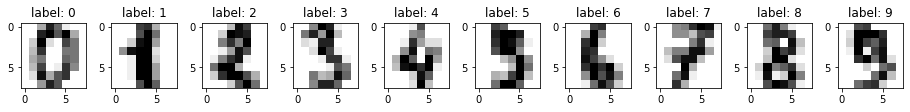

In [21]:
from sklearn import datasets
import matplotlib.pyplot as plt

# load the digits dataset
digits_dataset = datasets.load_digits()

def visualize_image(subplot, image, label):
    subplot.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    subplot.set_title(f'label: {label}')

# display the first 10 images with labels
fig, axs = plt.subplots(1, 10, figsize=(16, 1.2))    # 10 subplots
for index in range(10):
    visualize_image(axs[index], digits_dataset.images[index], digits_dataset.target[index])
plt.show()    # show plot

In [22]:
# convert image to floating point matrix
x = digits_dataset.images.astype('float32')

# reshape input x such that it is a 1D vector for each sample
samples, rows, cols = x.shape
x = x.reshape(samples, rows * cols) 

# normalize values to range [0, 1]
x =  x / 16.0 

Die Label des Digit-Datensatzes geben an, um welche Ziffer es sich handelt.
Verarbeiten Sie die Label derart, dass sie für die Unterscheidung von geraden und ungeraden Zahlen geeignet sind.
Gerade Zahlen sollen dabei das Klassenlabel 0 bekommen und ungerade Zahlen das Klassenlabel 1.

In [23]:
# get labels as teacher
t = digits_dataset.target

# change the labels to 0 for even numbers and 1 for odd numbers
for i in range(len(t)):
    if t[i] % 2 == 0:    # even number
        t[i] =  0
    else:    # odd number
        t[i] =  1

# convert teacher to array
t = np.array(t)

Nun müssen die Daten noch in Trainings- und Validierungsdaten aufgeteilt werden.

In [24]:
from sklearn.model_selection import train_test_split

# split data to training and validation data (use 15% of data for validation)
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.15, random_state=42)

Um die korrekte Funktionsweise eines Neuronalen Netzwerks nachzuweisen, sollte zunächst nur ein einzelner Batch verwendet werden.
Das Neuronale Netzwerk muss in der Lage sein, diesen Trainingsbatch auswendig zu lernen und einen Fehler nahe Null zu erzeugen.

In [25]:
# use only 32 samples as one single batch for training to show that the implemented framework works
x_train = x_train[:32, :]
t_train = t_train[:32]

Um zu testen, ob die gewünschte Datenvorverarbeitung erreicht wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [26]:
import numpy as np
print(f'(number of samples, feature dimension) of x_train = {x_train.shape}')
print(f'(number of samples, feature dimension) of x_val = {x_val.shape}')
print(f'number of samples of t_train = {t_train.shape}')
print(f'number of samples of t_val = {t_val.shape}')
print(f'unique labels in t_train = {np.unique(t_train)}')
print(f'minimum value of x_train = {np.min(x_train)}')
print(f'maximum value of x_train = {np.max(x_train)}')

(number of samples, feature dimension) of x_train = (32, 64)
(number of samples, feature dimension) of x_val = (270, 64)
number of samples of t_train = (32,)
number of samples of t_val = (270,)
unique labels in t_train = [0 1]
minimum value of x_train = 0.0
maximum value of x_train = 1.0


In [27]:
# define the neural network
class Network(Module):
    """implements a multi layer perceptron (MLP)
    with one hidden layer of 10 neurons and one output layer of a single neuron

    hint: construction similar to PyTorch
          --> compare with "Code Beispiel 2.9 [2/4] CNN in PyTorch: Netzwerk definieren" in slides of chapter 2
    """

    def __init__(self):
        """create and initialize the two fully connected layers"""
        # create fully connected layer: 64-dimensional input, 10 hidden neurons
        self.fc1 = Linear(64, 10)
        # create fully connected layer: 10 hidden neurons as input, 1 output neuron
        self.fc2 = Linear(10 , 1) 

    def forward(self, x):
        """forward pass for input x"""
        # calculation of 1st layer: input x --> fully connected layer --> relu
        x = relu(self.fc1(x))
        # calculation of 2nd layer: output of 1st layer x --> fully connected layer --> sigmoid
        x = sigmoid(self.fc2(x))  
        return x

    def parameters(self):
        """return parameters (weights, bias) of all layers in the network"""
        fc1_parameters = self.fc1.parameters()    # get the list of parameters for 1st layer
        fc2_parameters = self.fc2.parameters()    # get the list of parameters for 2nd layer
        return fc1_parameters + fc2_parameters    # concatenate the lists

    def __call__(self, x):
        """call function for forward pass with input x
        type checking needed to enable batch processing in case x is a numpy array"""
        if isinstance(x, (np.ndarray, np.float32)):    # in case it is a numpy array
            if x.ndim > 1:    # if it has more than one dimension (batch dimension + feature dimension)
                x = x.tolist()    # make it a list
                y = []    # output will be a list of multiple elements, start with empty list
                for x_i in x:    # for each element x_i in the list x
                    y_i = self.forward(x_i)    # calculate the output for sample x_i
                    y.append(y_i)    # and add it to the list
                return y    # return the list of outputs
            else:    # only the feature dimension
                x = x.tolist()    # make it a list
                self.forward(x)    # process it
        else:    # in case x is a single input
            return self.forward(x)    # process it

    def __repr__(self):
        """string representation of this class"""
        return f'MLP[{str(self.fc1)} --> ReLU --> {str(self.fc2)} --> Sigmoid]'

# set random seed for reproducibility (weight initialization is random)
random.seed(1337)

# create the neural network
net =  Network()

# print information about the neural network
print(net)
print(f'number of parameters = {len(net.parameters())}')

MLP[FCLayer[Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs)] --> ReLU --> FCLayer[Neuron(10 inputs)] --> Sigmoid]
number of parameters = 661


In [28]:
import numpy as np

def log(x):
    if isinstance(x, (list, tuple)):    # in case of more then one input
        out = []    # output will be a list of multiple elements, start with empty list
        for x_i in x:    # for each element x_i in the list x
            out_i = log(x_i)    # calculate the element's non-linear output
            out.append(out_i)    # and add it to the list
        return out    # return the list of outputs
    else:
        # x needs to be an instance of class Value
        if not isinstance(x, Value):
            x = Value(x)

        # calculate the logarithm output
        forward_result = np.log(x.data)

        # create a new Value (self.__class__) that can store the result and the calculation tree
        out = Value(forward_result, (x,))

        # backward path: deviation
        def _backward():
            # calculate derivative of activation function (log)
            derivative_log = 1.0 / x.data
            # update gradient
            x.grad += derivative_log * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

Implementieren Sie den Binary Cross Entropy (BCE) Loss, der die Prädiktionen des Neuronalen Netzwerks $\mathbf{\underline{y}}$ und die zugehörigen Teacher-Werte $\mathbf{\underline{t}}$ als Eingabe bekommt.

In [29]:
def binary_cross_entropy_loss(y, t):
    # initialize loss with zero
    loss = 0

    # loop throug all outputs y and labels t simultaniously
    for y_i, t_i in zip(y, t):
        # calculate loss for this output and teacher (see above for the equation inside the sum)
        loss_i = t_i * log(y_i) +  (1 - t_i) * log(1 - y_i)  
        # add it to overall loss
        loss += loss_i

    # devide loss by the number of samples
    n_samples = len(y)
    loss = -(1 / n_samples) * loss

    return loss

Um zu testen, ob die gewünschte Funktionalität umgesetzt wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [30]:
y = [Value(0.9), Value(0.1), Value(0.4)]
t = [1, 0, 1]
loss = binary_cross_entropy_loss(y, t)
for i in range(len(y)):
    y[i].grad = 0


loss.backward()
print(f'loss = {loss}')
print(f'y = {y}')

loss = Value(data=0.37567058772993583, grad=1)
y = [Value(data=0.9, grad=-0.37037037037037035), Value(data=0.1, grad=0.37037037037037035), Value(data=0.4, grad=-0.8333333333333333)]


In [31]:
def accuracy(y, t):
    # count number of samples and number of correct predictions
    correct = 0
    total = 0

    # loop throug all outputs y and labels t simultaniously
    for y_i, t_i in zip(y, t):
        # binarize the decisions of the neural network (class label 1 if y_i > 0.5, class label 0 otherwise)
        if y_i.data > 0.5:
            predicted_class = 1  
        else:
            predicted_class = 0 

        # count this sample
        total += 1

        # increase number of correct predictions if prediction for current sample is correct
        if predicted_class == t_i:
            correct += 1

    # calculate accuracy
    acc = correct / total

    return acc

In [32]:
y = [Value(0.9), Value(0.1), Value(0.4)]
t = [1, 0, 1]
acc = accuracy(y, t)
print(f'acc = {acc}')

acc = 0.6666666666666666


In [33]:
def train_step(X, t, net):
    # forward pass with input data X
    y = net(X)
    # compute loss and accuracy
    loss = binary_cross_entropy_loss(y, t) 
    training_data_accuracy = accuracy(y, t)

    # reset gradients from previous train step
    net.zero_grad()   

    # calculate all gradients
    loss.backward()

    # update every parameter with sgd
    learning_rate = 0.25
    for parameter in net.parameters():
        parameter.data = parameter.data - parameter.grad * learning_rate

    return net, loss, training_data_accuracy

In [34]:
def test_step(X, t, net):
    # forward pass with input data X
    y = net(X) 
    # calculate performance measures (compare network outputs y and teacher t)
    loss = binary_cross_entropy_loss(y, t)  # bitte Code ergaenzen <---------------- [Luecke (68)]
    acc = accuracy(y, t)  

    return loss, acc

In [35]:
%%time
# lists to store performance measures during training
loss_list = []
accuracy_list = []
val_loss_list = []
val_accuracy_list = []

# start training
for step in range(100):    # 100 training steps
    # perform one training step (training data: x_train, t_train; neural network: net)
    net, loss, train_acc = train_step(x_train, t_train, net) 
    # store performance measures
    loss_list.append(loss.data)
    accuracy_list.append(train_acc * 100)

    # print output and validate every 5th training step
    if step % 5 == 0:
        # perform one validation step (validation data: x_val, t_val; neural network: net)
        val_loss, val_accuracy = test_step(x_val, t_val, net) 
        # store performance measures
        val_loss_list.append(val_loss.data)
        val_accuracy_list.append(val_accuracy * 100)

        # print training progress
        print(f"step {step:>3}:  training:   loss = {loss.data:.4f}, accuracy = {(train_acc * 100):.3f}%\n           validation: loss = {val_loss.data:.4f}, accuracy = {(val_accuracy * 100):.3f}%\n")

    
# final validation step
val_loss, val_accuracy = test_step(x_val, t_val, net)

# store final performance measures
loss_list.append(loss.data)
accuracy_list.append(train_acc * 100)
val_loss_list.append(val_loss.data)
val_accuracy_list.append(val_accuracy * 100)

# print final training result
print('final result:')
print(f"step 100:  training:   loss = {loss.data:.4f}, accuracy = {(train_acc * 100):.3f}%\n           validation: loss = {val_loss.data:.4f}, accuracy = {(val_accuracy * 100):.3f}%\n")

step   0:  training:   loss = 0.6866, accuracy = 56.250%
           validation: loss = 0.6875, accuracy = 51.111%

step   5:  training:   loss = 0.6506, accuracy = 56.250%
           validation: loss = 0.6666, accuracy = 51.111%

step  10:  training:   loss = 0.6056, accuracy = 62.500%
           validation: loss = 0.6352, accuracy = 64.815%

step  15:  training:   loss = 0.5427, accuracy = 84.375%
           validation: loss = 0.5902, accuracy = 81.111%

step  20:  training:   loss = 0.4605, accuracy = 90.625%
           validation: loss = 0.5376, accuracy = 82.593%

step  25:  training:   loss = 0.3775, accuracy = 93.750%
           validation: loss = 0.4936, accuracy = 82.963%

step  30:  training:   loss = 0.3089, accuracy = 93.750%
           validation: loss = 0.4663, accuracy = 83.333%

step  35:  training:   loss = 0.2572, accuracy = 93.750%
           validation: loss = 0.4555, accuracy = 83.333%

step  40:  training:   loss = 0.2185, accuracy = 93.750%
           validation: 

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Folgende Ausgabe sollte angezeigt werden:
    <br><code>step   0:  training:   loss = 0.6866, accuracy = 56.250%
           validation: loss = 0.6875, accuracy = 51.111%

step   5:  training:   loss = 0.6506, accuracy = 56.250%
           validation: loss = 0.6666, accuracy = 51.111%

step  10:  training:   loss = 0.6056, accuracy = 62.500%
           validation: loss = 0.6352, accuracy = 64.815%

step  15:  training:   loss = 0.5427, accuracy = 84.375%
           validation: loss = 0.5902, accuracy = 81.111%

step  20:  training:   loss = 0.4605, accuracy = 90.625%
           validation: loss = 0.5376, accuracy = 82.593%

step  25:  training:   loss = 0.3775, accuracy = 93.750%
           validation: loss = 0.4936, accuracy = 82.963%

step  30:  training:   loss = 0.3089, accuracy = 93.750%
           validation: loss = 0.4663, accuracy = 83.333%

step  35:  training:   loss = 0.2572, accuracy = 93.750%
           validation: loss = 0.4555, accuracy = 83.333%

step  40:  training:   loss = 0.2185, accuracy = 93.750%
           validation: loss = 0.4540, accuracy = 82.593%

step  45:  training:   loss = 0.1888, accuracy = 93.750%
           validation: loss = 0.4604, accuracy = 82.963%

step  50:  training:   loss = 0.1655, accuracy = 93.750%
           validation: loss = 0.4702, accuracy = 82.593%

step  55:  training:   loss = 0.1466, accuracy = 96.875%
           validation: loss = 0.4843, accuracy = 82.963%

step  60:  training:   loss = 0.1311, accuracy = 96.875%
           validation: loss = 0.5000, accuracy = 83.704%

step  65:  training:   loss = 0.1182, accuracy = 96.875%
           validation: loss = 0.5176, accuracy = 82.963%

step  70:  training:   loss = 0.1073, accuracy = 96.875%
           validation: loss = 0.5357, accuracy = 82.963%

step  75:  training:   loss = 0.0979, accuracy = 96.875%
           validation: loss = 0.5545, accuracy = 82.963%

step  80:  training:   loss = 0.0898, accuracy = 96.875%
           validation: loss = 0.5733, accuracy = 82.222%

step  85:  training:   loss = 0.0827, accuracy = 100.000%
           validation: loss = 0.5923, accuracy = 81.852%

step  90:  training:   loss = 0.0764, accuracy = 100.000%
           validation: loss = 0.6112, accuracy = 81.852%

step  95:  training:   loss = 0.0708, accuracy = 100.000%
           validation: loss = 0.6295, accuracy = 81.481%

final result:
step 100:  training:   loss = 0.0667, accuracy = 100.000%
           validation: loss = 0.6443, accuracy = 81.481%</code>
</details>

---
#### [ X ] Visualisieren Sie die Bewertungsmaße Loss und Accuracy über den Verlauf des Trainings. Was ist zu beobachten?

Visualisieren Sie die während des Trainings gespeicherten Bewertungsmaße Loss und Accuracy für die Trainings- und Validierungsdaten.

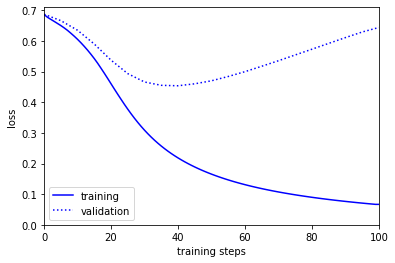

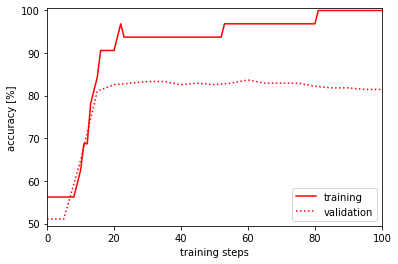

In [36]:
# plot loss curves (data stored in loss_list and val_loss_list)
plt.plot(np.arange(len(loss_list)), loss_list,
         'b-', label='training')    # blue color, solid line for training curve
plt.plot(np.arange(len(val_loss_list)) * 5, val_loss_list,
         'b:', label='validation')    # blue color, dotted line for validation curve
plt.ylabel('loss')
plt.xlabel('training steps')
plt.legend(loc='lower left')
plt.axis([0, 100, 0, 0.71])
plt.show()

# plot accuracy curves (data stored in accuracy_list and val_accuracy_list)
plt.plot(np.arange(len(accuracy_list)), accuracy_list, 
         'r-', label='training')    # red color, solid line for training curve
plt.plot( np.arange(len(val_accuracy_list)) * 5 , val_accuracy_list, 
         'r:', label='validation')    # red color, dotted line for validation curve
plt.ylabel('accuracy [%]')
plt.xlabel('training steps')
plt.legend(loc='lower right')
plt.axis([0, 100, 49.5, 100.5])
plt.show()

In [37]:
# === Ergaenzen Sie hier Ihren Code zu Praktikumsaufgabe P2.1 ===
# Falls Sie Teile dieses Notebooks benoetigen, dann kopieren Sie diese bitte an diese Stelle.
# Diese Code-Zelle sollte losgeloest vom restlichen Jupyter Notebook ausfuehrbar sein.
t = digits_dataset.target
for i in range(len(t)): t[i] = t[i] % 2 == 0
t = np.array(t)
batch_size=32
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.15, random_state=42)
steps_except_last_batch = len(x_train)-(len(x_train)%batch_size)
net =  Network()

def train_step2(X, t, learning_rate):
    y = net(X) 
    loss = binary_cross_entropy_loss(y, t)  
    training_data_accuracy = accuracy(y, t)  
    net.zero_grad()  
    loss.backward()
    for parameter in net.parameters():
        parameter.data = parameter.data - parameter.grad * learning_rate
    return net, loss, training_data_accuracy

def learn_batch(epoch_nr, x_train, t_train, learning_rate):
    loss_list = []
    accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    for step in range(100):  
        net, loss, train_acc = train_step2(x_train, t_train, learning_rate)
        loss_list.append(loss.data)
        accuracy_list.append(train_acc * 100)
        if step % 10 == 0 or train_acc > 0.99:
            # perform one validation step (validation data: x_val, t_val; neural network: net)
            val_loss, val_accuracy = test_step(x_val, t_val, net)  
            # store performance measures
            val_loss_list.append(val_loss.data)
            val_accuracy_list.append(val_accuracy * 100)
          
            # print training progress
            print(f"Epoch {epoch_nr:>2}, Step {step:>3}:\n\ttraining:   loss = {loss.data:.4f}, accuracy = {(train_acc * 100):.3f}%\n\tvalidation: loss = {val_loss.data:.4f}, accuracy = {(val_accuracy * 100):.3f}%\n")
            if val_accuracy >= 0.95 or train_acc > 0.99: 
                return loss.data, train_acc, val_loss, val_accuracy
    return loss.data, train_acc, val_loss, val_accuracy
                
for i in range(0, steps_except_last_batch, batch_size):
    loss, train_acc, val_loss, val_accuracy = learn_batch(int(i/32), x_train[i:i+batch_size, :], t_train[i:i+batch_size], learning_rate=0.09)
    if val_accuracy >= 0.95: 
        print('Final Result')
        break

Epoch  0, Step   0:
	training:   loss = 0.6744, accuracy = 78.125%
	validation: loss = 0.6747, accuracy = 67.778%

Epoch  0, Step  10:
	training:   loss = 0.6451, accuracy = 62.500%
	validation: loss = 0.6608, accuracy = 61.852%

Epoch  0, Step  20:
	training:   loss = 0.6106, accuracy = 65.625%
	validation: loss = 0.6398, accuracy = 65.185%

Epoch  0, Step  30:
	training:   loss = 0.5633, accuracy = 84.375%
	validation: loss = 0.6068, accuracy = 74.815%

Epoch  0, Step  40:
	training:   loss = 0.5051, accuracy = 93.750%
	validation: loss = 0.5678, accuracy = 80.741%

Epoch  0, Step  50:
	training:   loss = 0.4411, accuracy = 90.625%
	validation: loss = 0.5274, accuracy = 83.333%

Epoch  0, Step  60:
	training:   loss = 0.3797, accuracy = 90.625%
	validation: loss = 0.4926, accuracy = 82.963%

Epoch  0, Step  70:
	training:   loss = 0.3273, accuracy = 90.625%
	validation: loss = 0.4671, accuracy = 83.333%

Epoch  0, Step  80:
	training:   loss = 0.2847, accuracy = 93.750%
	validation: 

In [38]:
# # === Ergaenzen Sie hier Ihren Code zu Praktikumsaufgabe P2.2 ===
# # Falls Sie Teile dieses Notebooks benoetigen, dann kopieren Sie diese bitte an diese Stelle.
# # Diese Code-Zelle sollte losgeloest vom restlichen Jupyter Notebook ausfuehrbar sein.

# 1. 100 training steps on the first batch of size 32, with PyTorch : Use the identical batch with 32 training examples to be able to show the exact equality of results.

# 2.Use the same initial weights. Show the equality of results for all learning steps by means of numerical calculations 
# (textual output on the differences in the loss for all learning steps, differences between the two implementations 
# with regard to the loss over all 100 learning steps total and final textual output). Show that the difference is 
# close to zero for identical initial weights. : Do not use random initialization in PyTorch, but use the random weights from the specially created minimal framework.

# 3 .Measure the speed difference (using Python means) that results from the use of the runtime-optimized calculations 
# in PyTorch compared to the self-implemented Python variant and output the runtimes.
%%time
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
import torch.nn.functional as F

n,m = x_train.shape
q,p = x_val.shape
trainset = np.hstack((x_train,np.reshape(t_train, (n, 1))))
testset = np.hstack((x_val,np.reshape(t_val, (q, 1))))
batch_size=32
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=270, shuffle=False)

#define network
class NetworkX(torch.nn.Module):
    def __init__(self):
        super(NetworkX, self).__init__()
        self.fc1 = torch.nn.Linear(64, 10)
        self.fc2 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

net = NetworkX()
bce = torch.nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.09, momentum=0)
correct = 0
total = 0
for step in range(101):
    for mtx in trainloader:
        if mtx.shape[0]<32: break
        x = mtx[:, :64].float()
        t = mtx[:, 64].reshape(batch_size,1).float()
        optimizer.zero_grad()
        logits = net(x)
        loss = bce(logits, t)
        train_acc = accuracy(logits, t)
        loss.backward()
        optimizer.step()
    if step % 5 == 0:
        with torch.no_grad():
            for mx in testloader:
                x = mx[:, :64].float()
                t = mx[:, 64].reshape(q,1).float()
                logits = net(x)
                val_loss = bce(logits, t)
                val_acc = accuracy(logits,t)
                print(f"step {step:>3}:  training:   loss = {loss.data:.4f}, accuracy = {(train_acc * 100):.3f}%\n           validation: loss = {val_loss.data:.4f}, accuracy = {(val_acc * 100):.3f}%\n")


step   0:  training:   loss = 0.6254, accuracy = 78.125%
           validation: loss = 0.6089, accuracy = 86.667%

step   5:  training:   loss = 0.1873, accuracy = 96.875%
           validation: loss = 0.2249, accuracy = 92.593%

step  10:  training:   loss = 0.1712, accuracy = 90.625%
           validation: loss = 0.1874, accuracy = 94.444%

step  15:  training:   loss = 0.2862, accuracy = 87.500%
           validation: loss = 0.1719, accuracy = 94.444%

step  20:  training:   loss = 0.1683, accuracy = 90.625%
           validation: loss = 0.1660, accuracy = 94.815%

step  25:  training:   loss = 0.2373, accuracy = 90.625%
           validation: loss = 0.1603, accuracy = 94.815%

step  30:  training:   loss = 0.0398, accuracy = 100.000%
           validation: loss = 0.1459, accuracy = 94.815%

step  35:  training:   loss = 0.1740, accuracy = 93.750%
           validation: loss = 0.1452, accuracy = 94.815%

step  40:  training:   loss = 0.1048, accuracy = 93.750%
           validation:

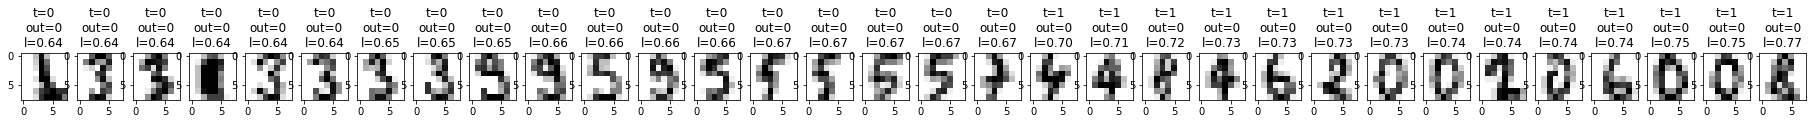

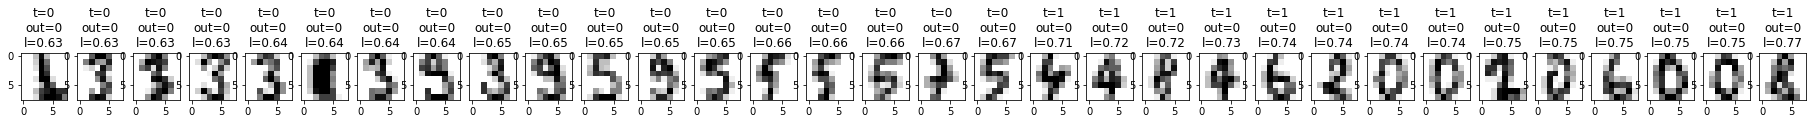

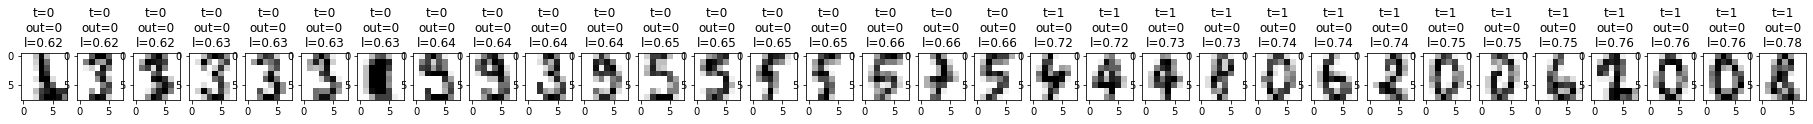

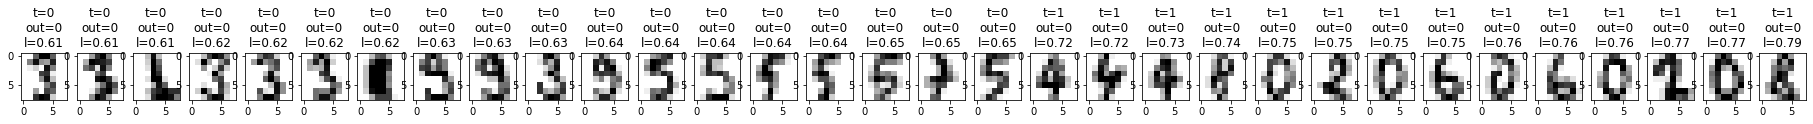

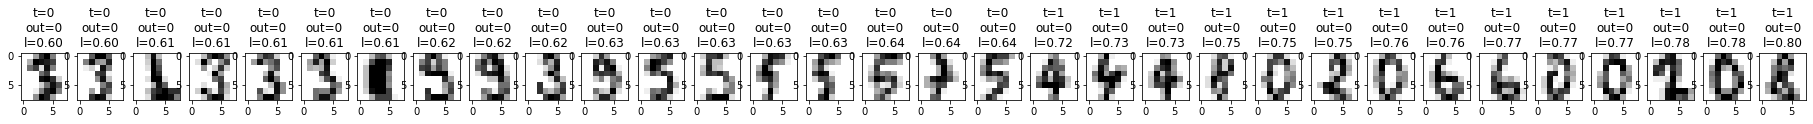

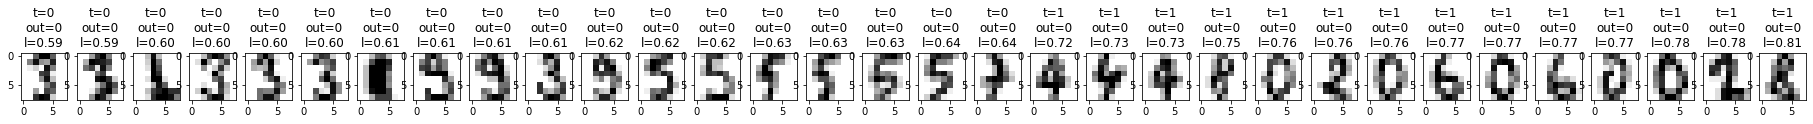

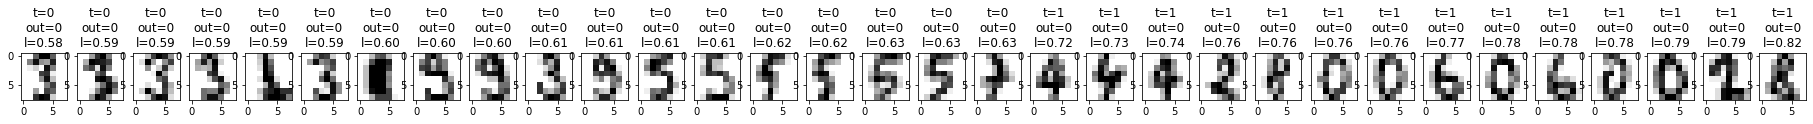

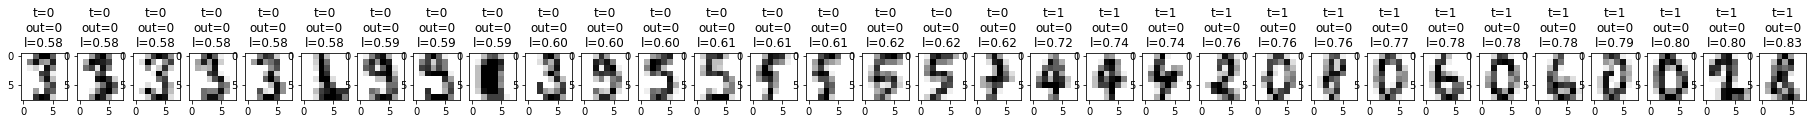

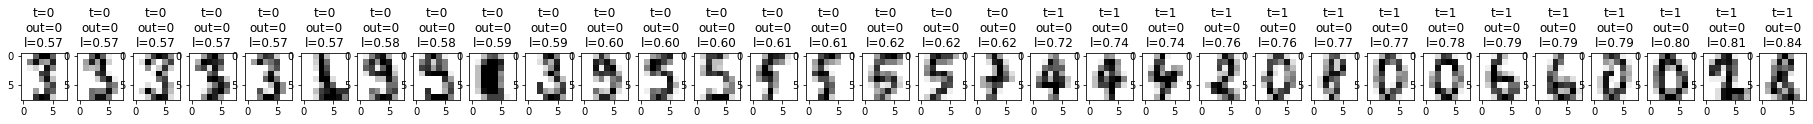

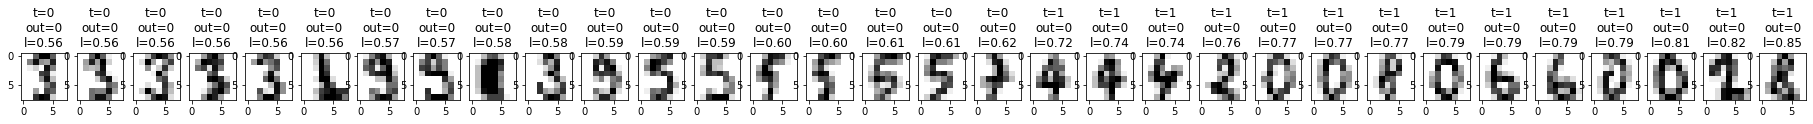

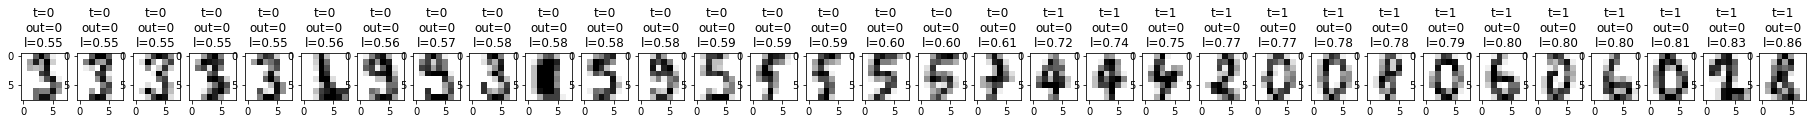

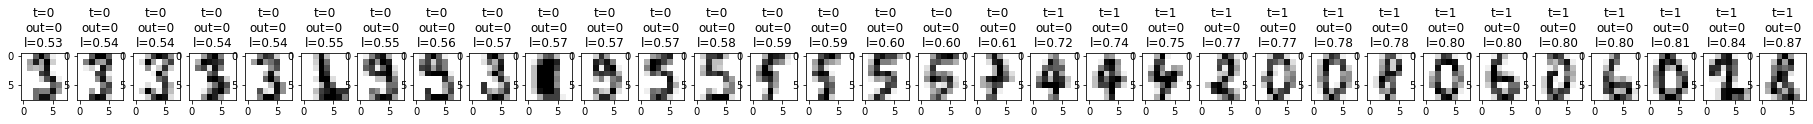

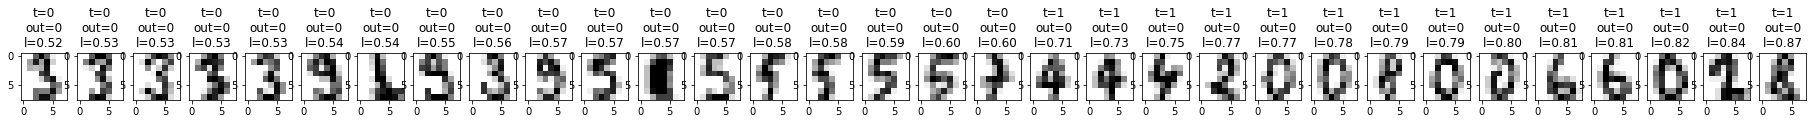

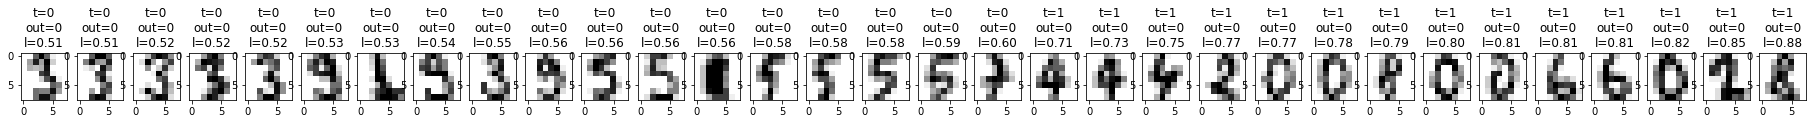

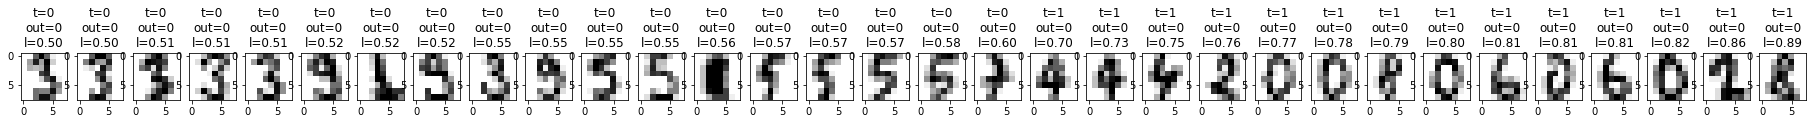

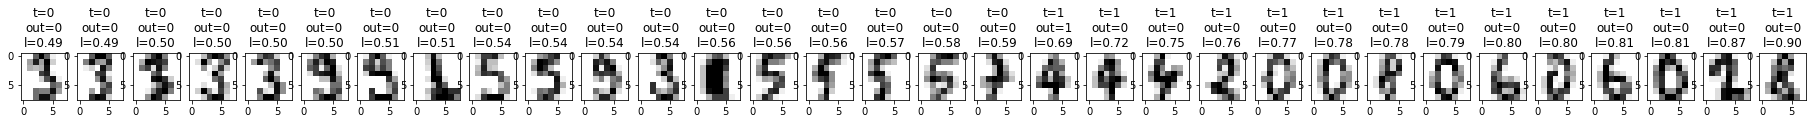

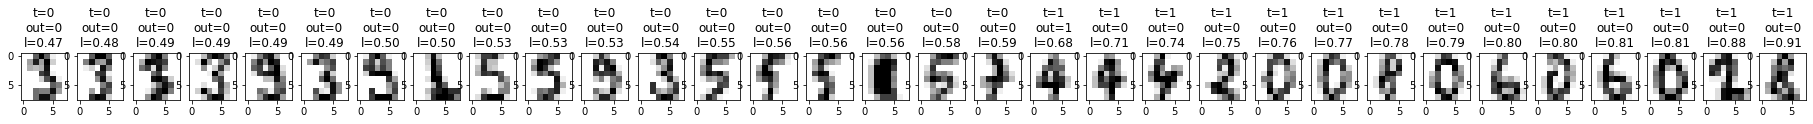

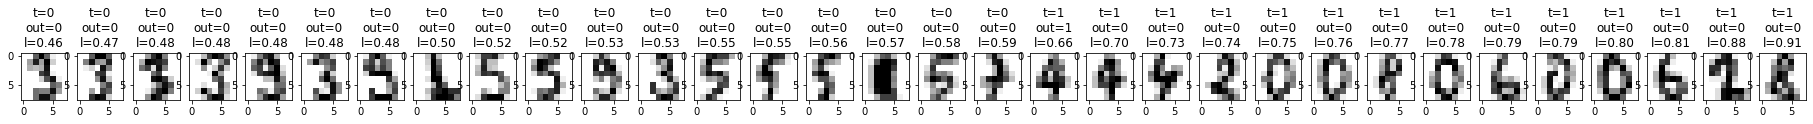

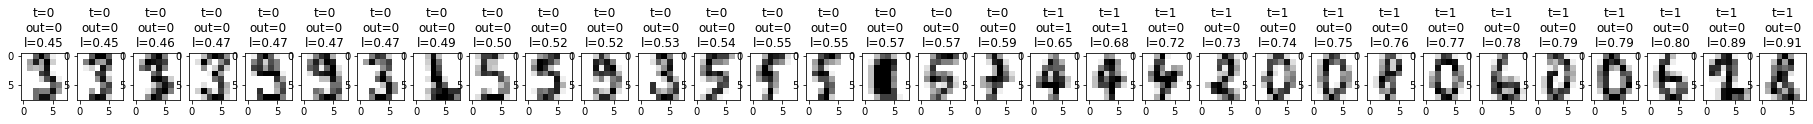

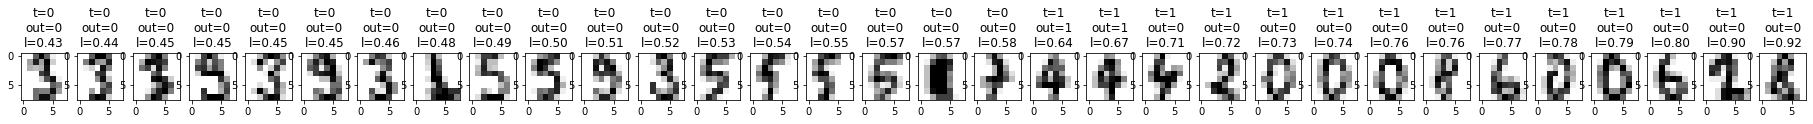

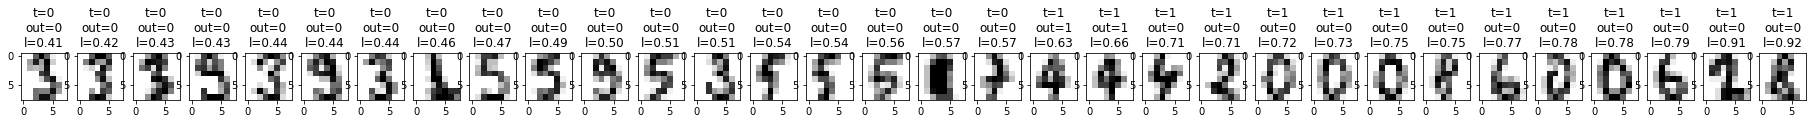

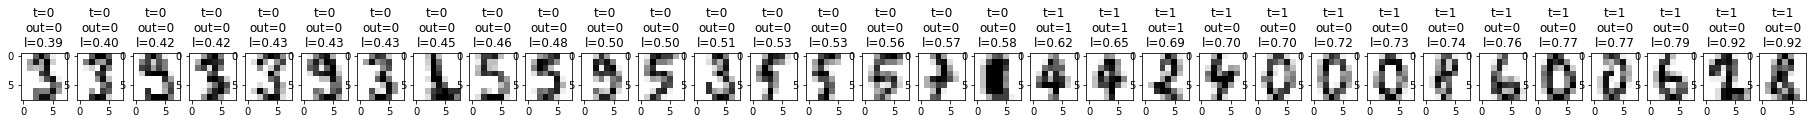

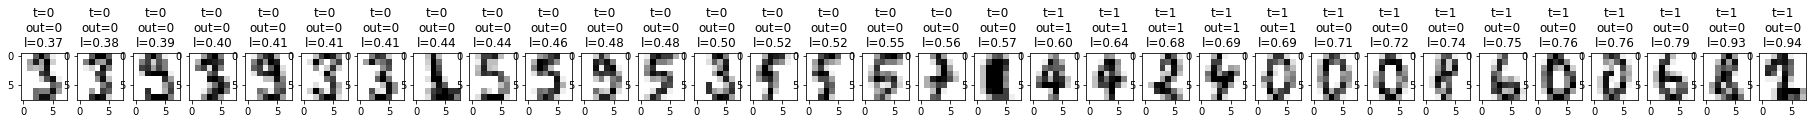

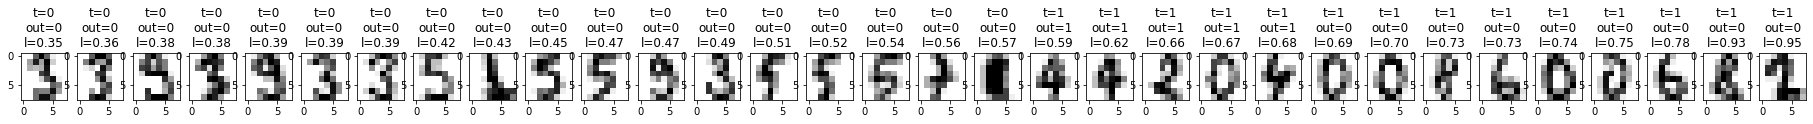

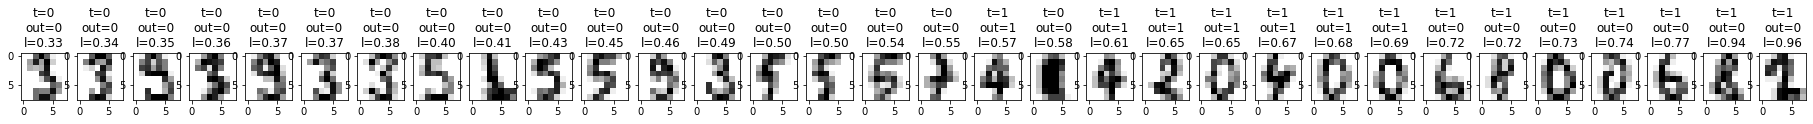

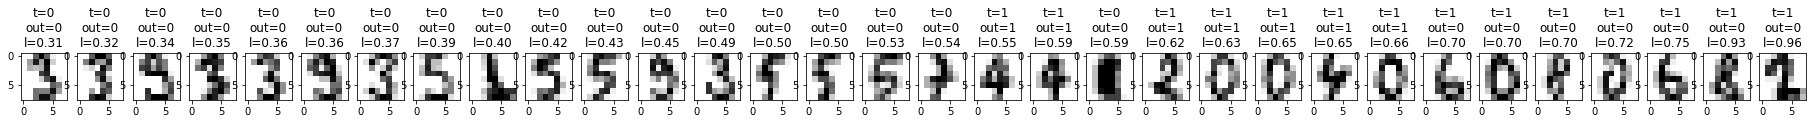

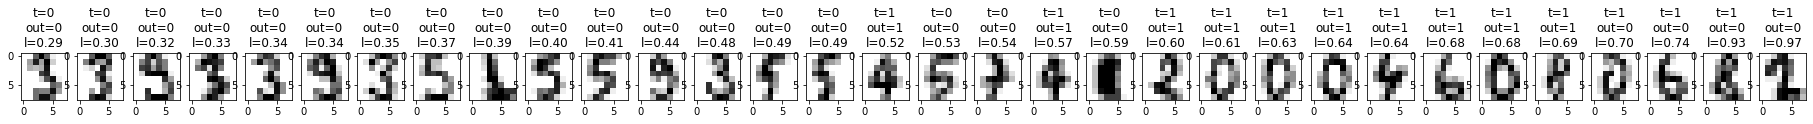

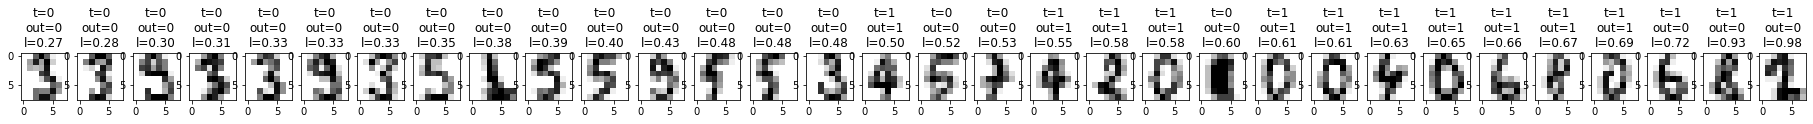

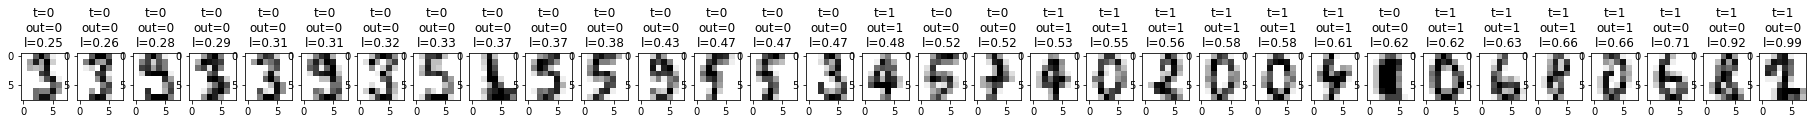

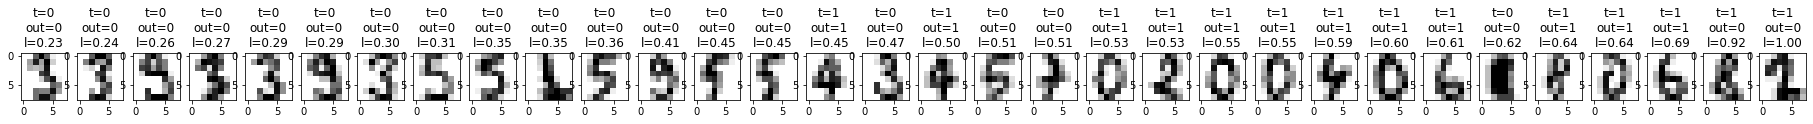

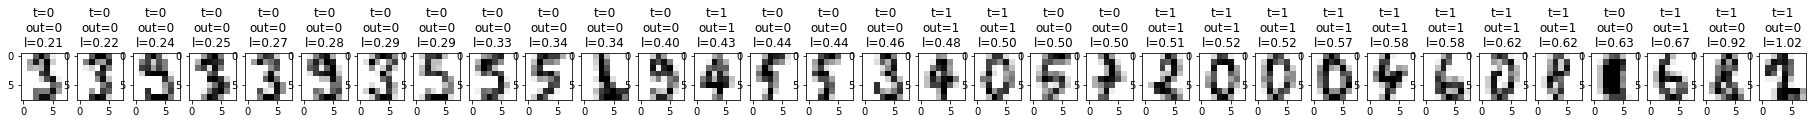

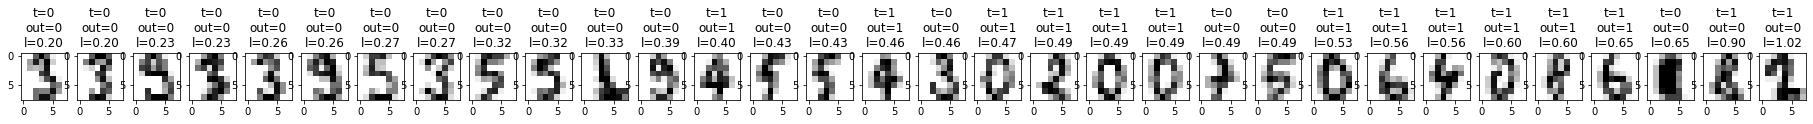

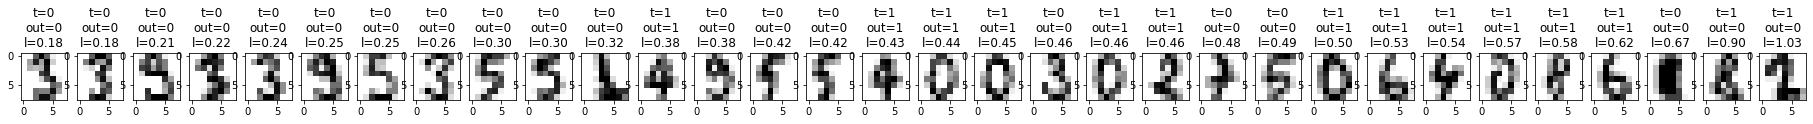

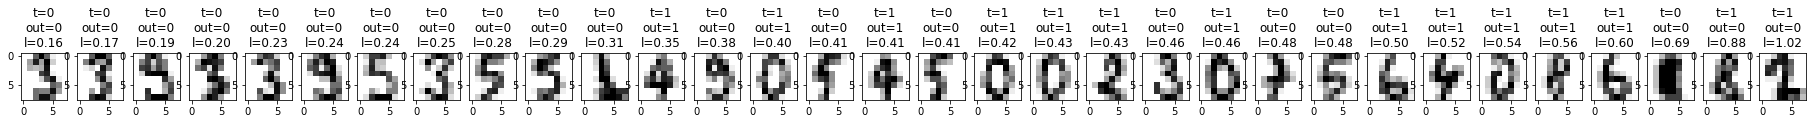

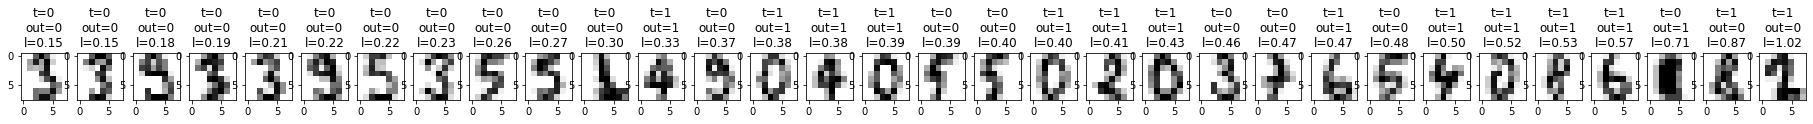

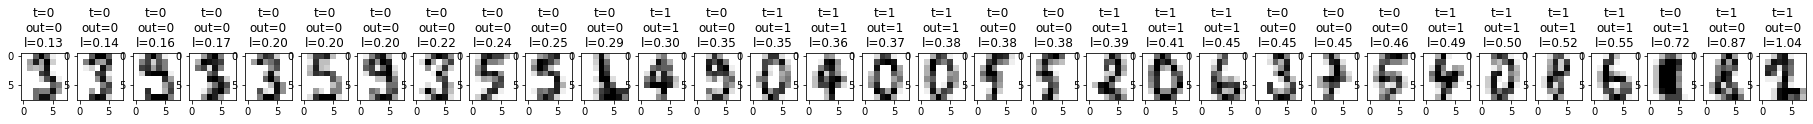

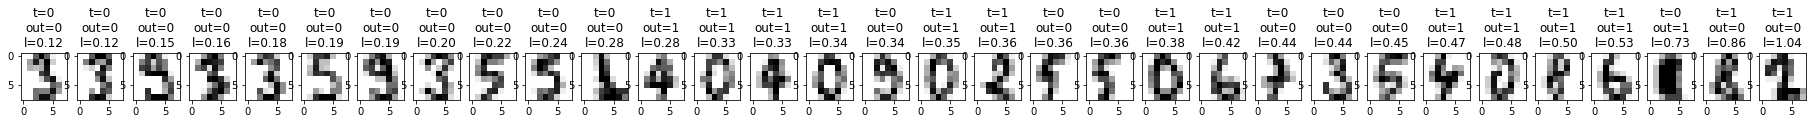

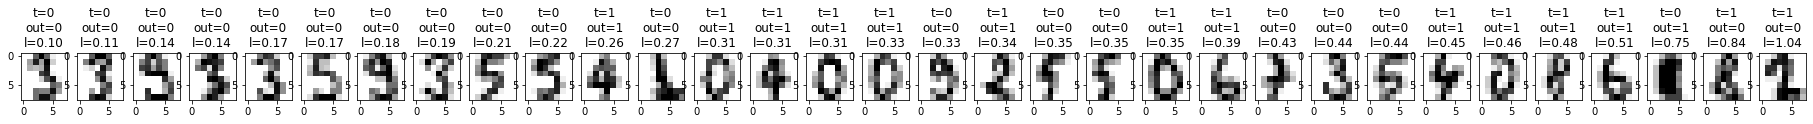

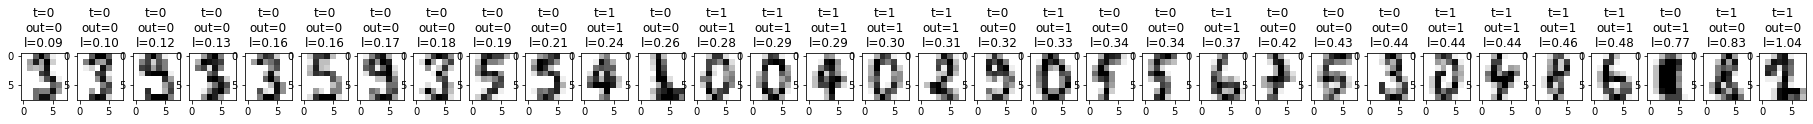

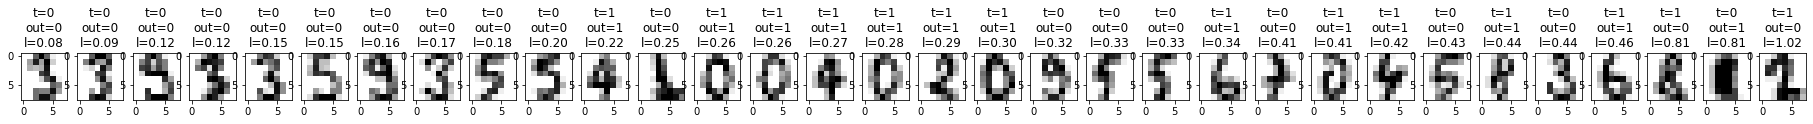

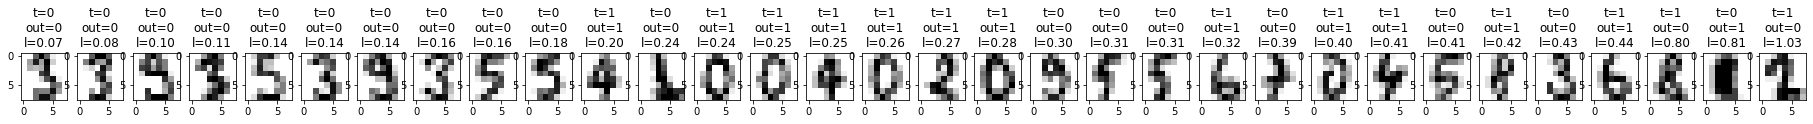

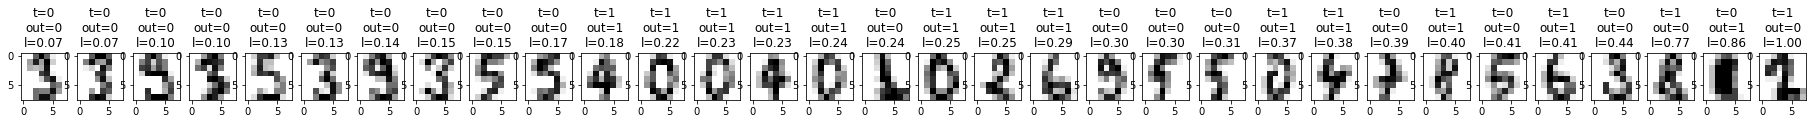

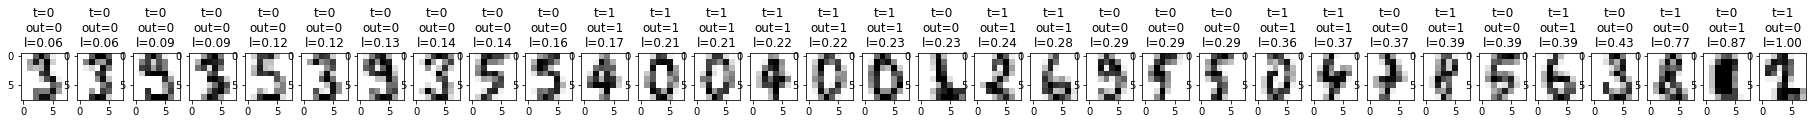

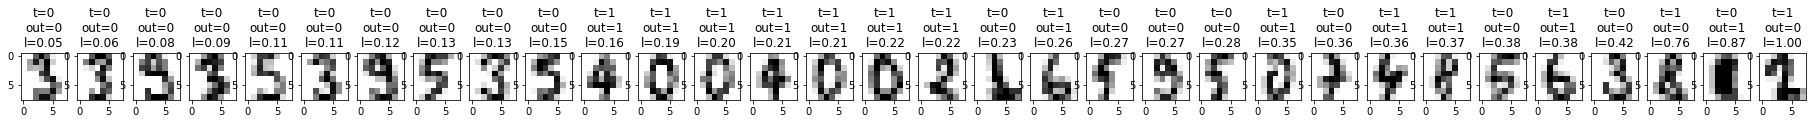

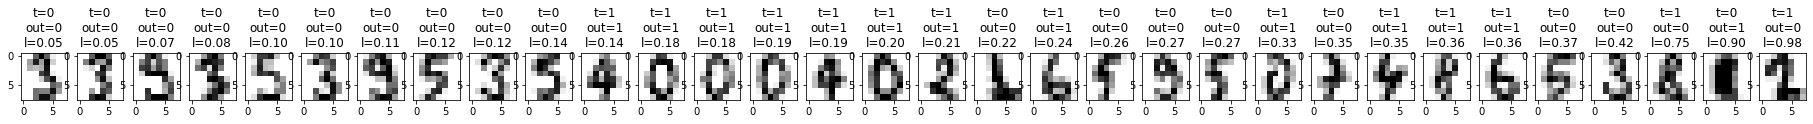

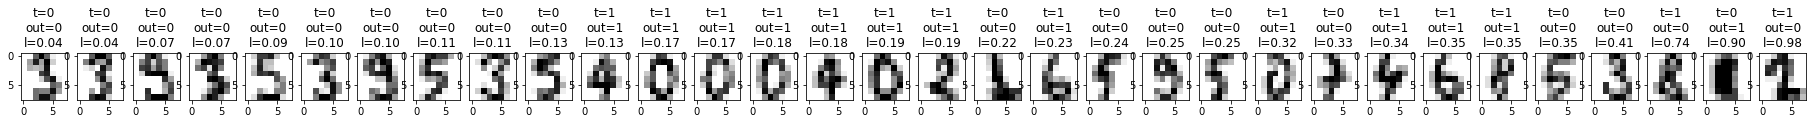

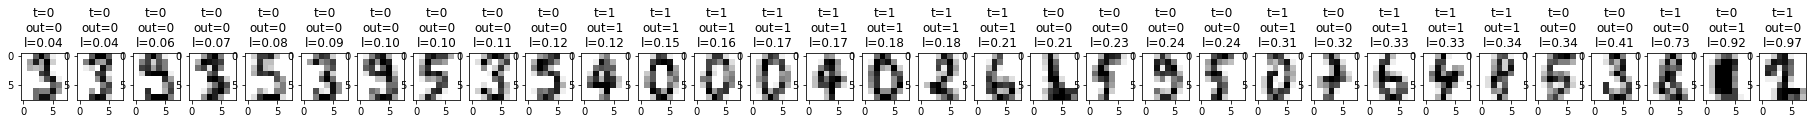

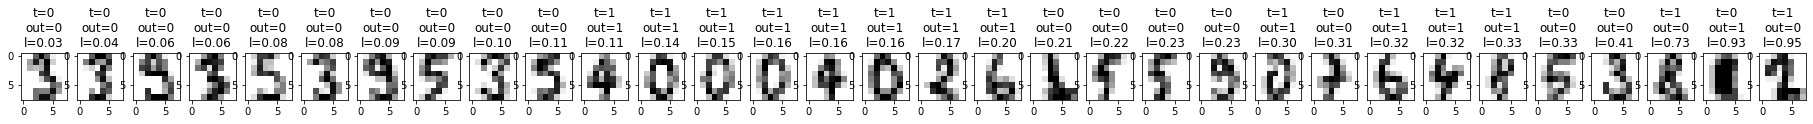

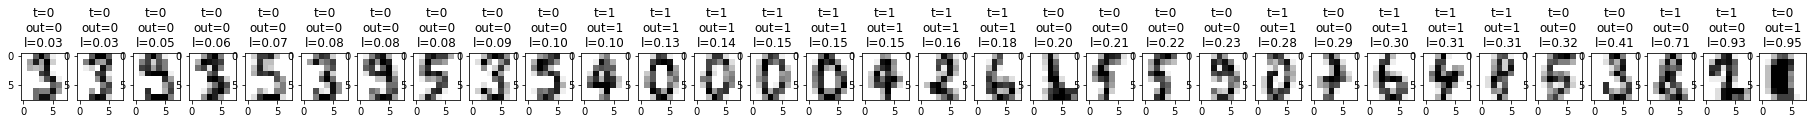

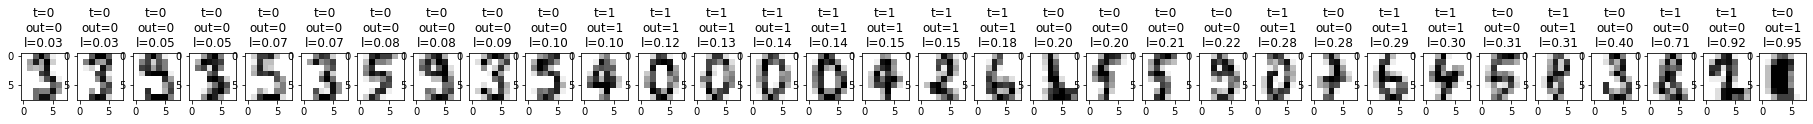

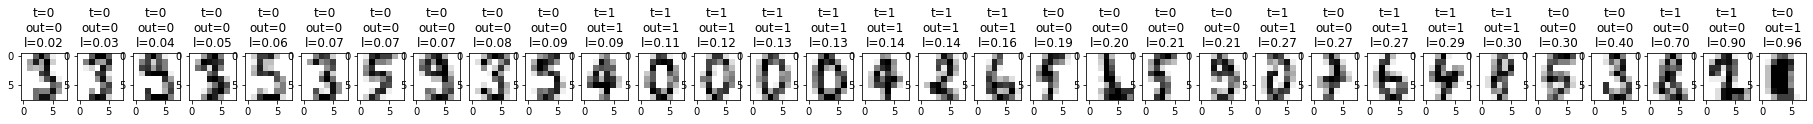

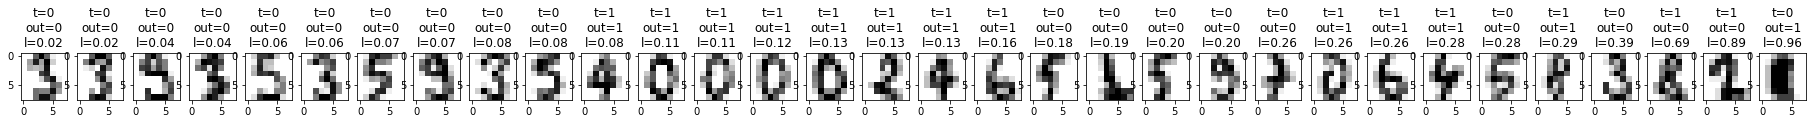

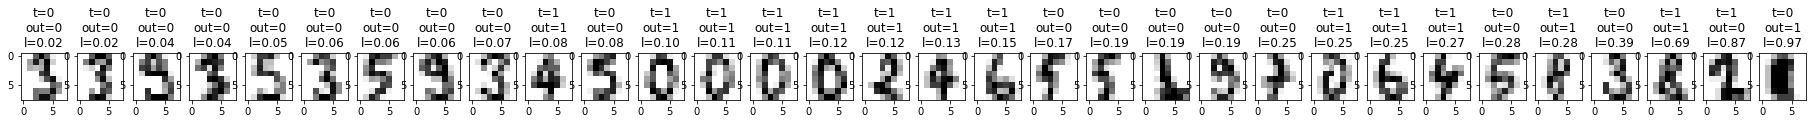

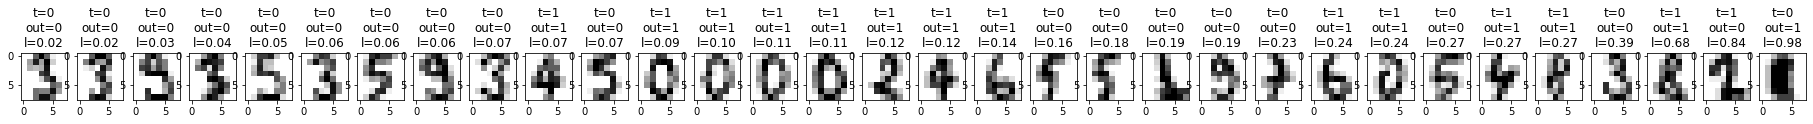

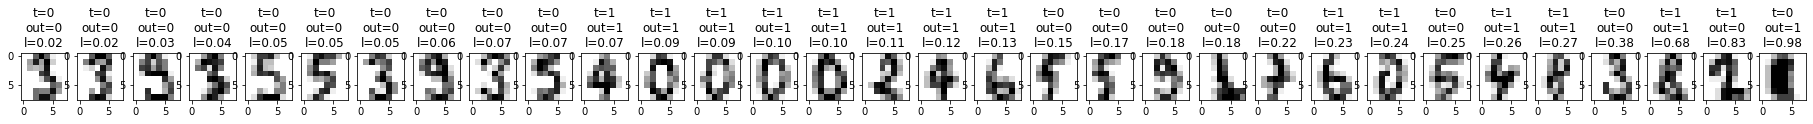

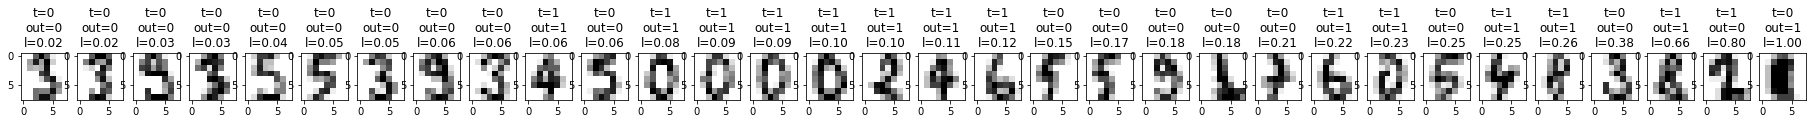

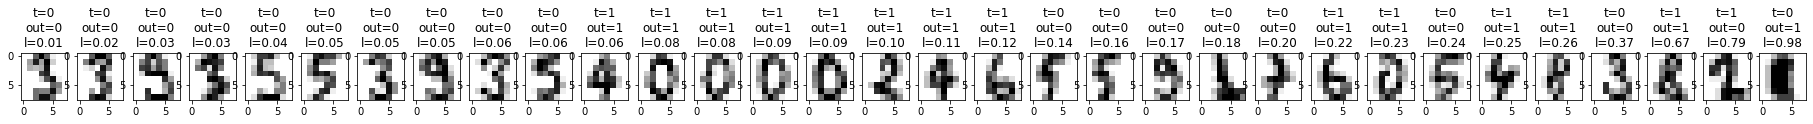

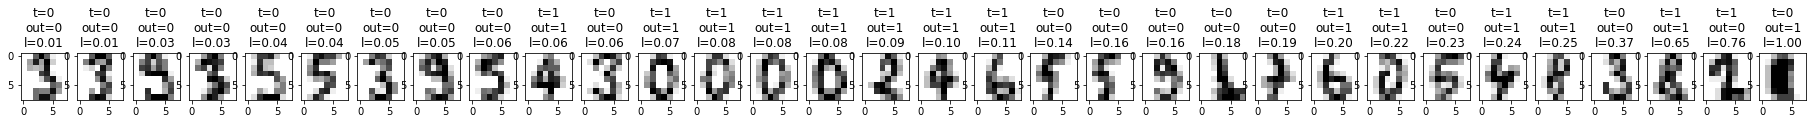

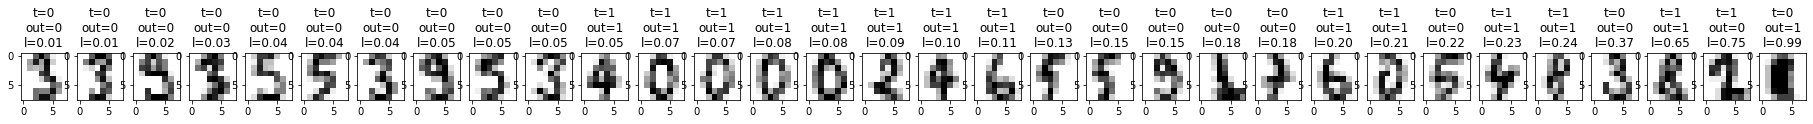

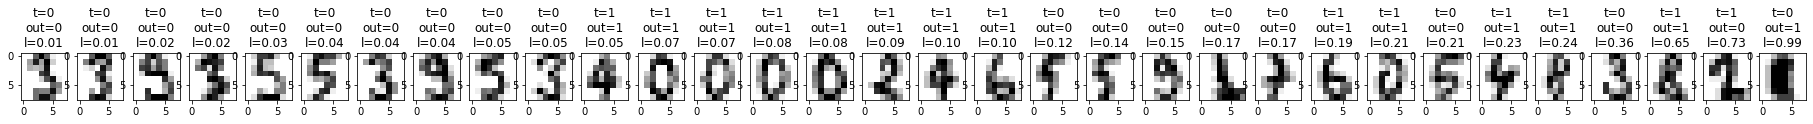

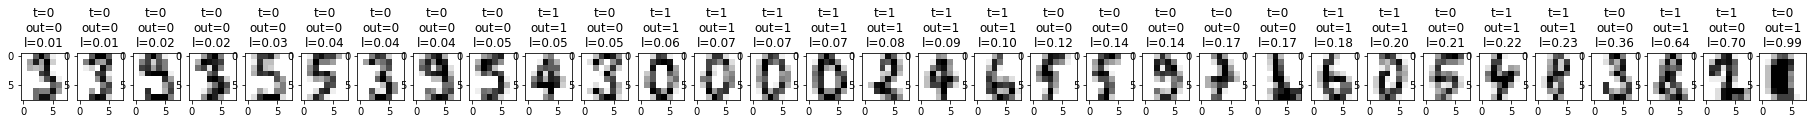

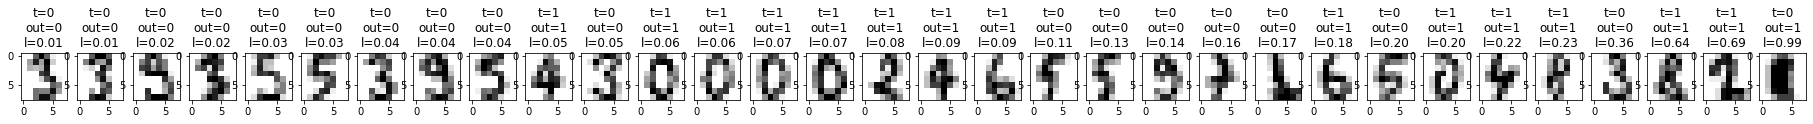

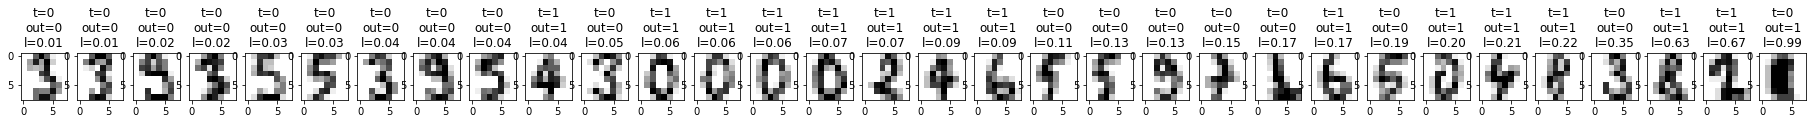

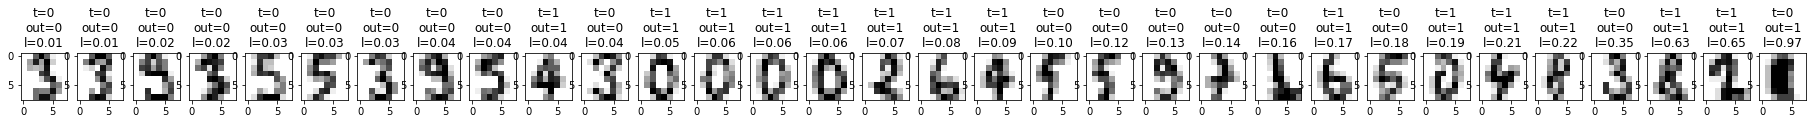

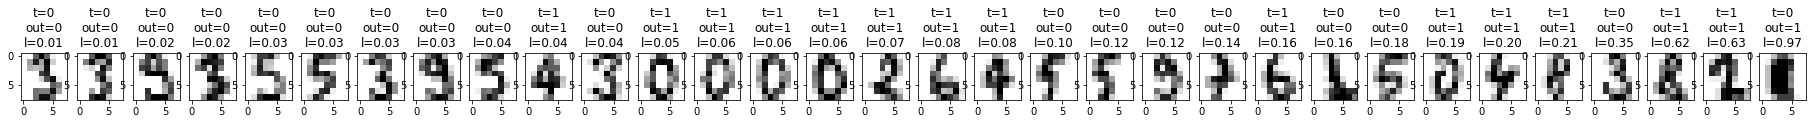

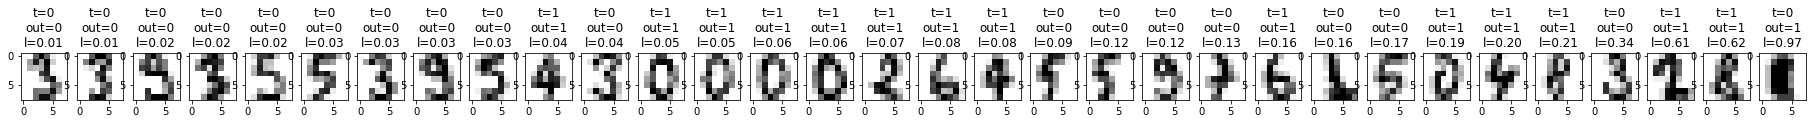

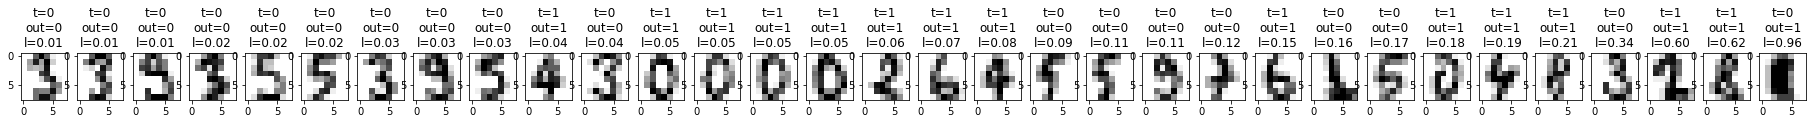

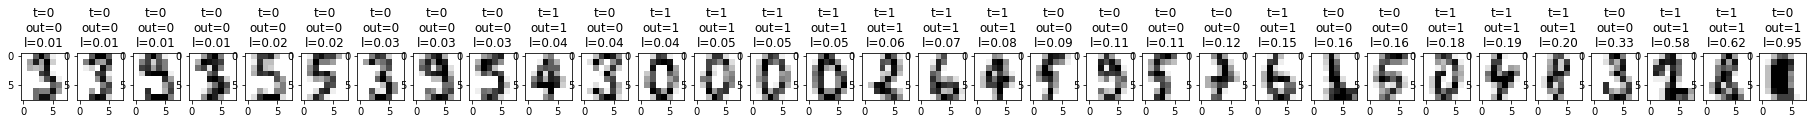

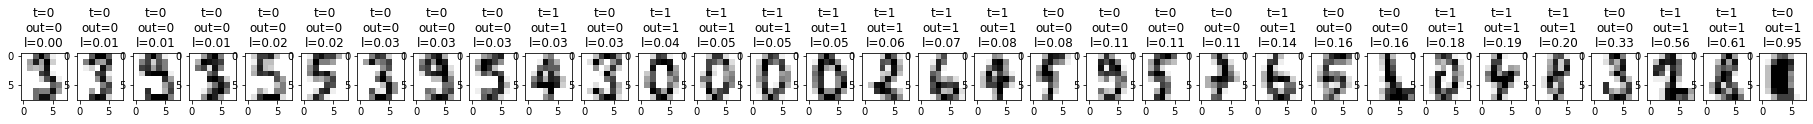

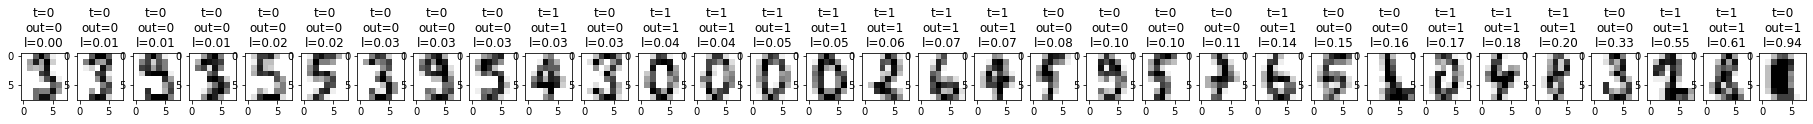

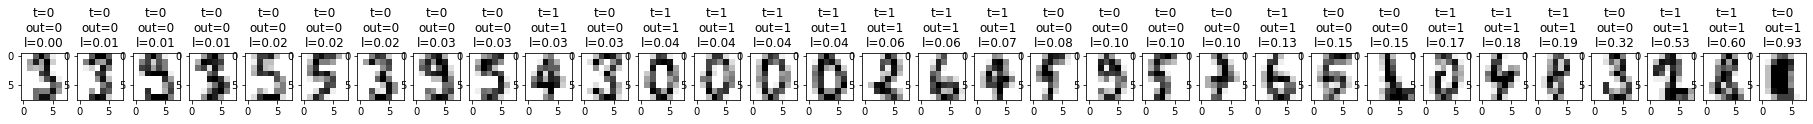

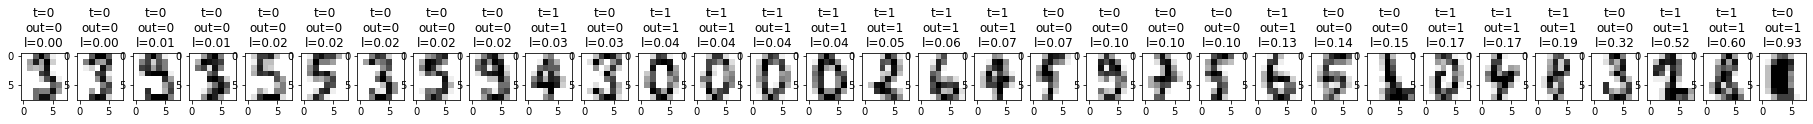

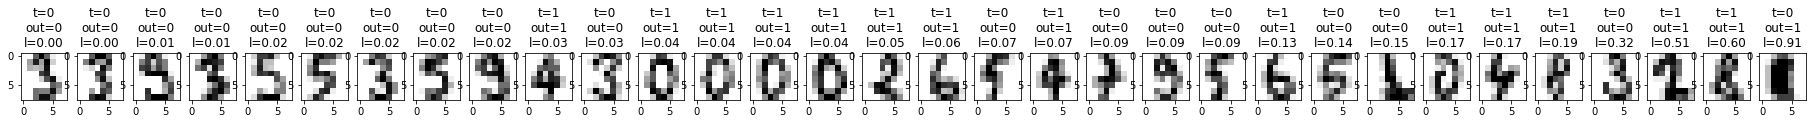

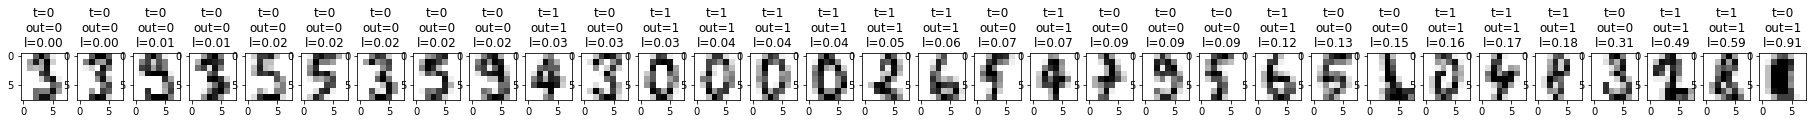

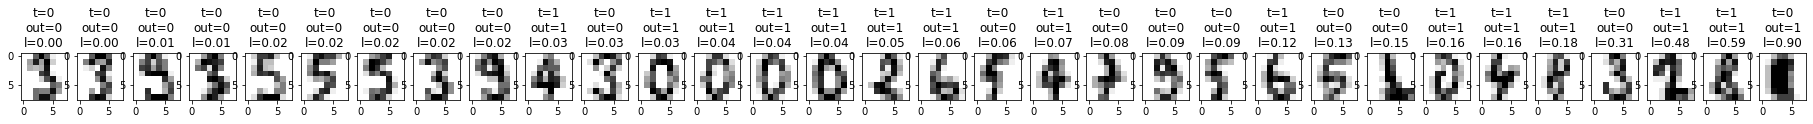

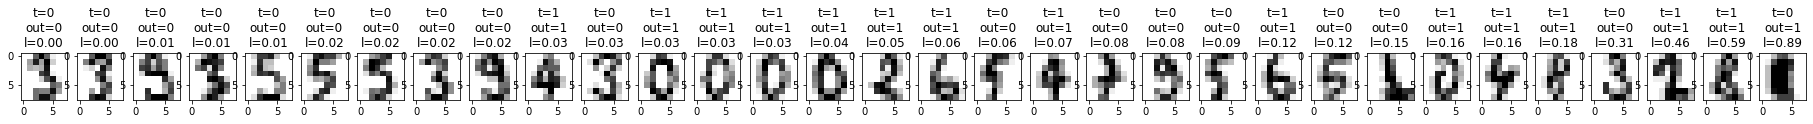

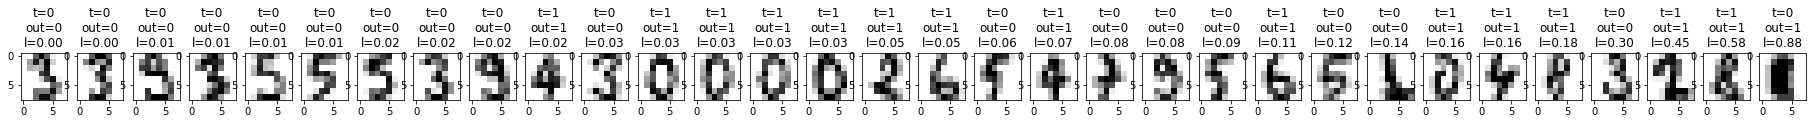

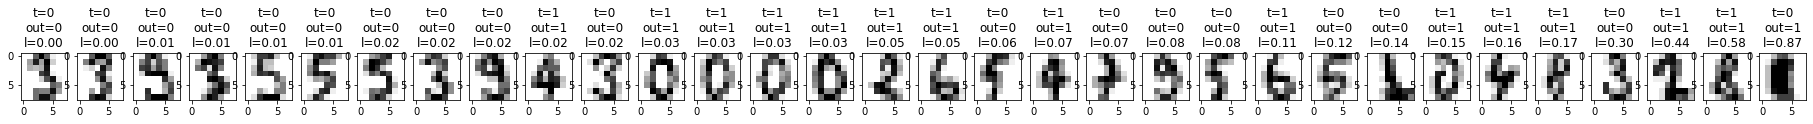

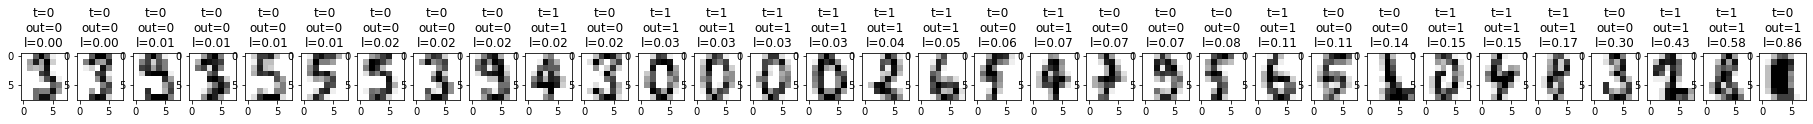

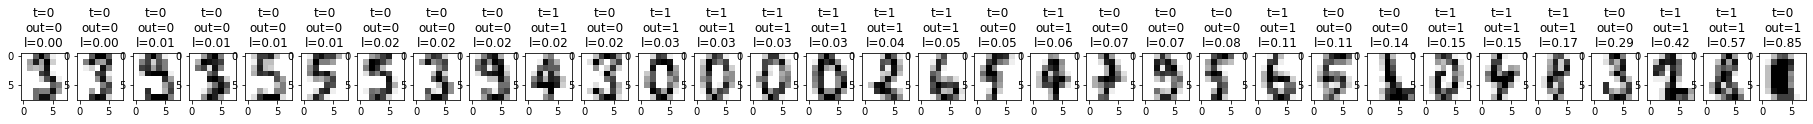

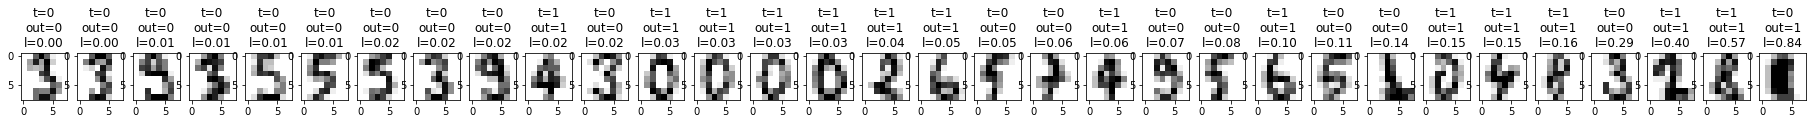

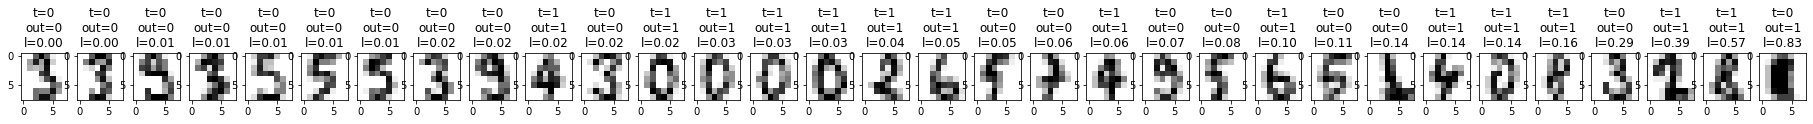

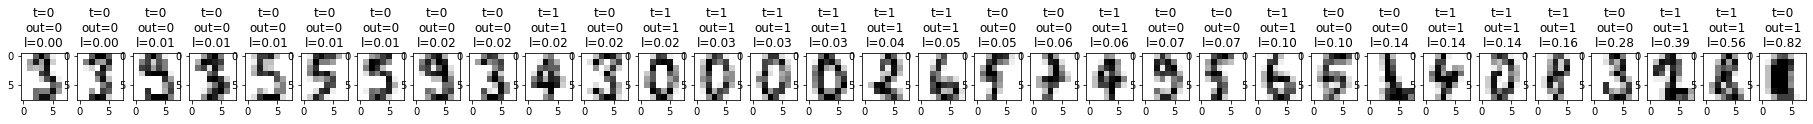

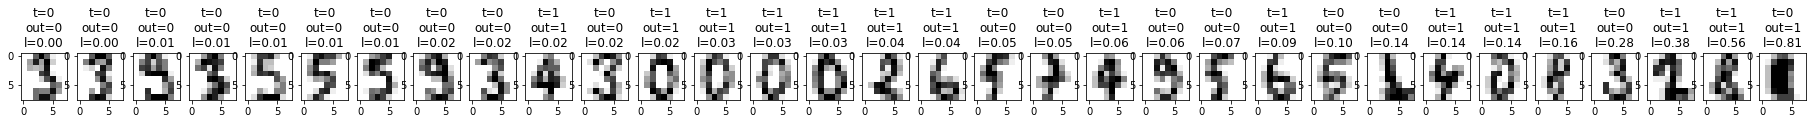

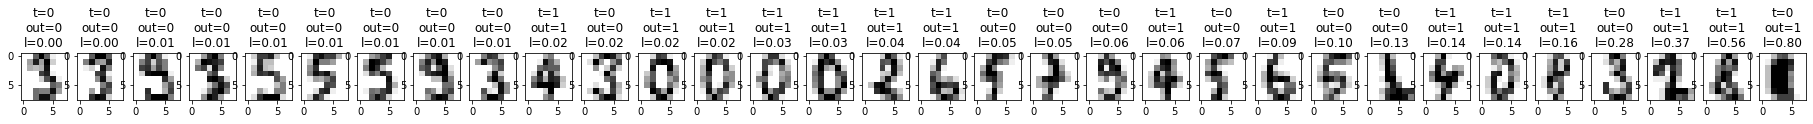

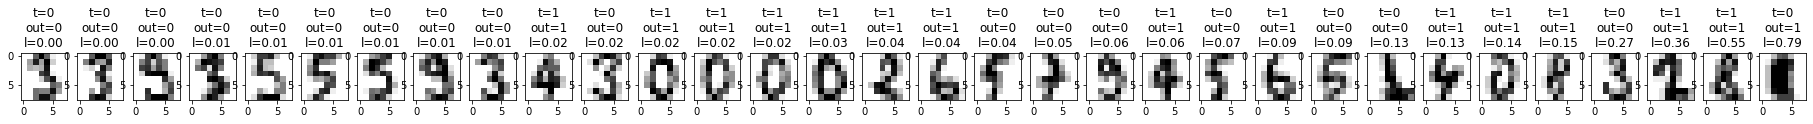

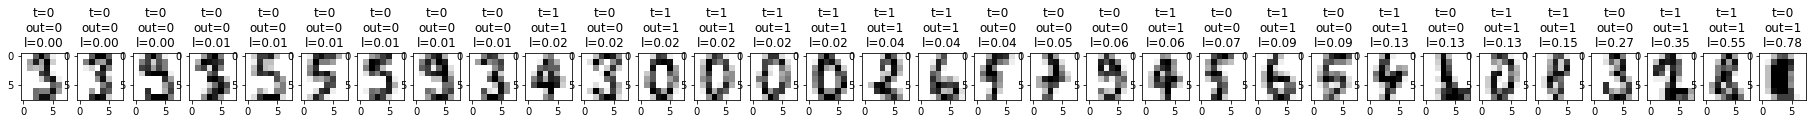

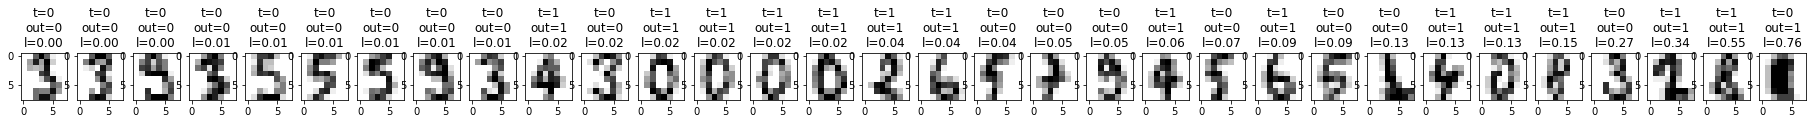

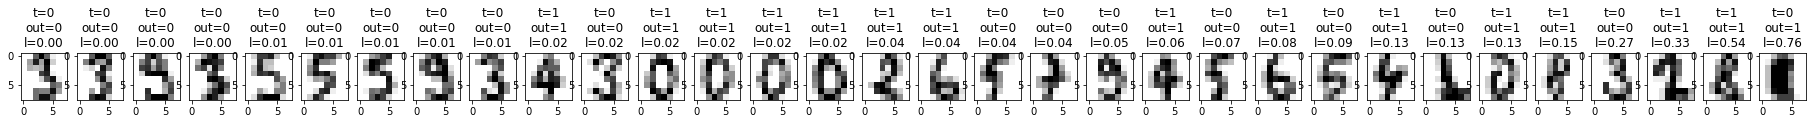

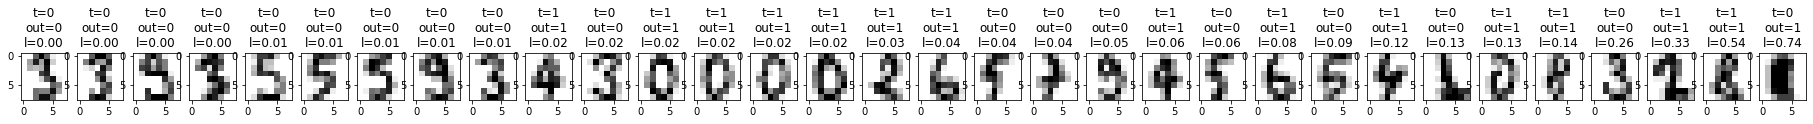

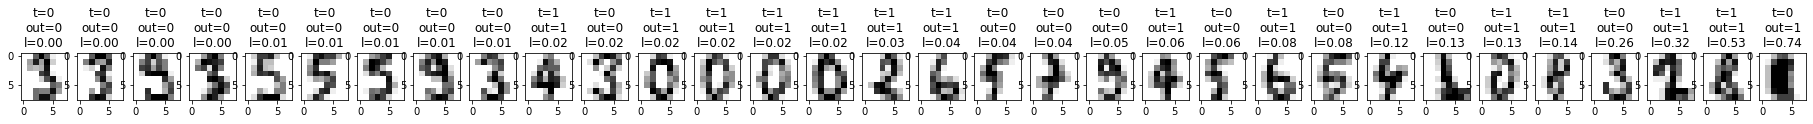

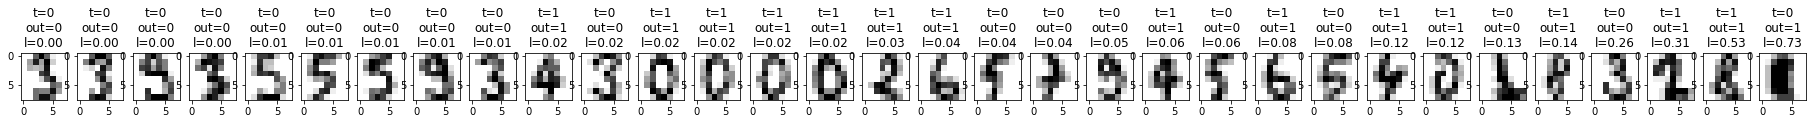

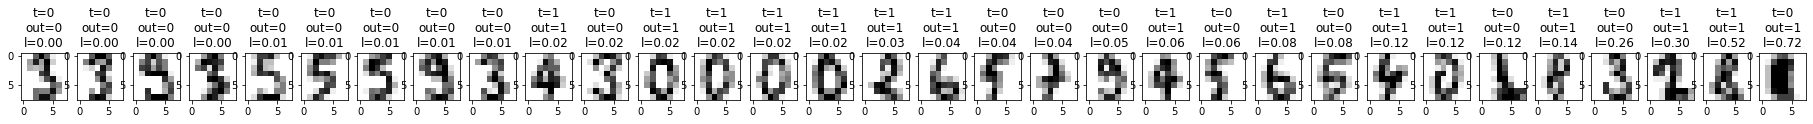

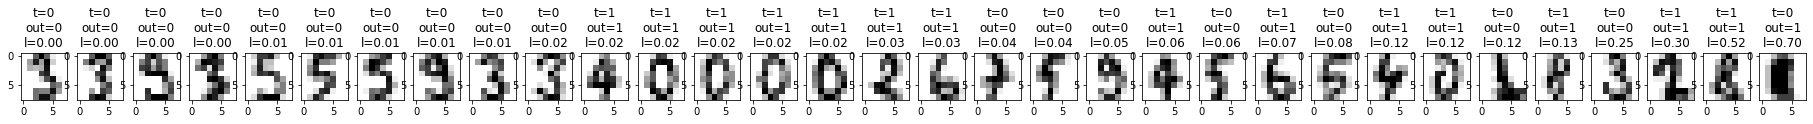

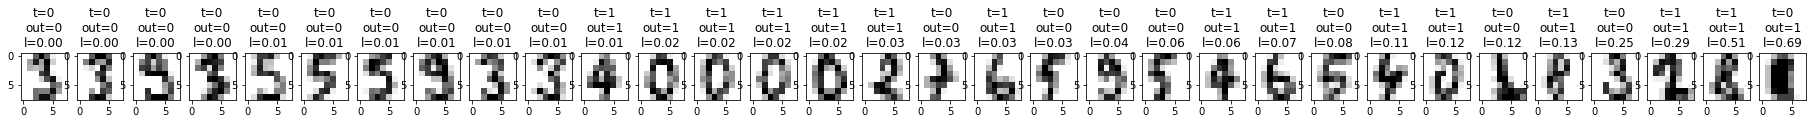

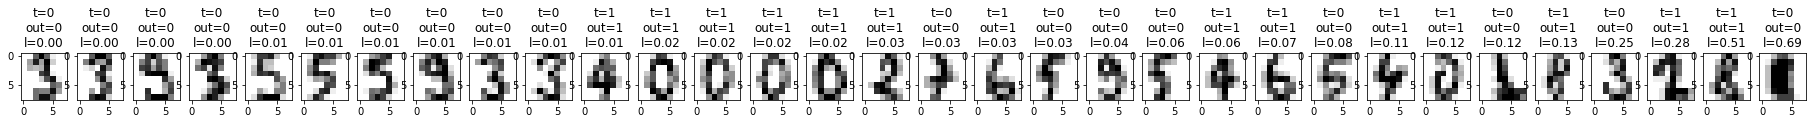

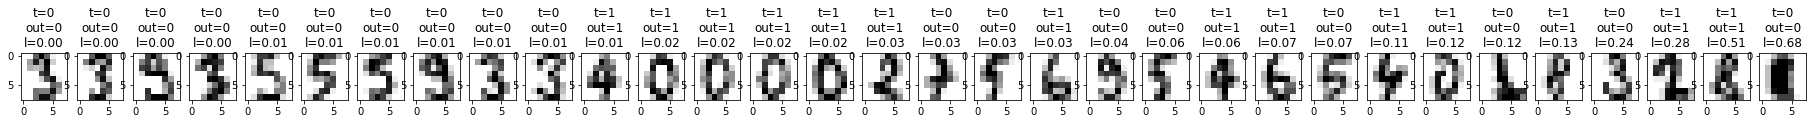

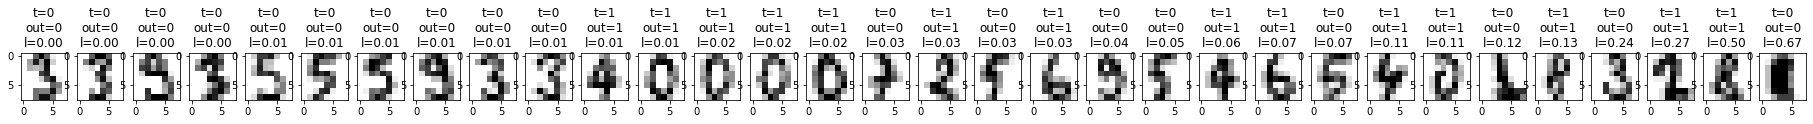

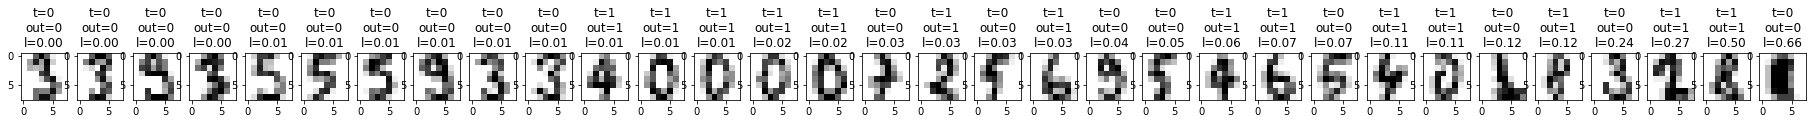

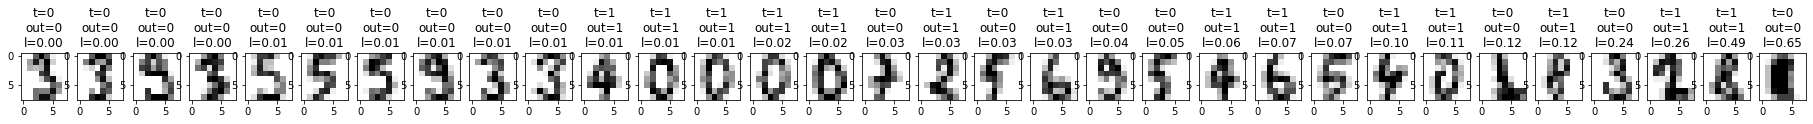


******	For Validation Images	*****



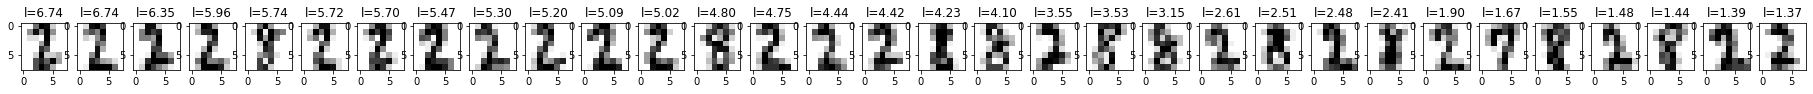

In [39]:
# === Ergaenzen Sie hier Ihren Code zu Praktikumsaufgabe P2.3 ===
# Falls Sie Teile dieses Notebooks benoetigen, dann kopieren Sie diese bitte an diese Stelle.
# Diese Code-Zelle sollte losgeloest vom restlichen Jupyter Notebook ausfuehrbar sein.
def test_step(X, t, net):
    y = net(X) 
    loss = binary_cross_entropy_loss(y, t)  
    acc = accuracy(y, t) 
    return loss, acc, y

net = Network()
x_train = x_train[:32, :]
t_train = t_train[:32]

for step in range(100): 
    ls = []
    net, loss, train_acc = train_step(x_train, t_train, net) 
    for index in range(t_train.shape[0]):
        z = test_step(np.array([x_train[index]]), np.array([t_train[index]]), net)
        y = 1 if z[2][0].data > 0.5 else 0
        ls.append((z[0].data, x_train[index], t_train[index], y))
    res = sorted(ls, key=lambda tup: tup[0])
    fig, axs = plt.subplots(1, 32, figsize=(32, 1.2)) 
    for index in range(len(res)):
        r = res[index]
        axs[index].imshow(r[1].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
        axs[index].set_title(f't={r[2]}\nout={r[3]}\nl={r[0]:.2f}')
    plt.show()

print('\n******\tFor Validation Images\t*****\n')
ls_val=[]
for i in range(t_val.shape[0]):
    loss = test_step(np.array([x_val[i]]), np.array([t_val[i]]), net)[0]
    ls_val.append((loss.data, x_val[i], t_val[i]))

res = sorted(ls_val, key=lambda tup: tup[0], reverse=True)[:32]
fig, axs = plt.subplots(1, 32, figsize=(32, 1.2)) 
for index in range(len(res)):
    r = res[index]
    axs[index].imshow(r[1].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    axs[index].set_title(f'l={r[0]:.2f}')
plt.show()